# ==============================================
# ASSIGNMENT 1: DECONSTRUCTING THE TRANSFORMER
# ==============================================

# Instructions:
## 1. Use Google Colab for all experiments (free GPU tier is sufficient).
## 2. This notebook provides a complementory solution for all parts of the assignment.

# ==============================================
# SUBMISSION INSTRUCTION
# ==============================================

## 1. Please write the name of the file as `Group_(number)_assignemnt_1_solution.ipynb`

##2. Only one member from one group needs to submit the solution, to avoid any duplicasy.

# PART:1

## Tiny Transformer Implementation

You have to complete the code where it's not completed!


"""
Complete the Code
"""

## Imports and Dataset

**We are using language translation dataset for this task (WMT14 DE-EN dataset)**

- Use first 30k samples for training `[You may Increase the training Samples for better results]`

- Use first 5k samples for validation `[You may Increase the validation Samples for better generalization results]`

- Use first 1k samples for testing.

- We have provided the Helping Functions throughout the notebook, you have to complete the Code and Run as per Questions asked in Assignemnt.

- We have Alreday created the `Dataloaders` to get you started quickely and to make sure resulst can be reproduced. Please do not change the Setup and Import Section.

In [ ]:
# ============================================
# SETUP AND IMPORTS
# ============================================

# Install required packages
!pip install -q torch matplotlib seaborn numpy
!pip install -q transformers datasets tokenizers
!pip install -q sacrebleu

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset

import math
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from typing import Tuple, Optional, List, Dict

from datasets import load_dataset
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.trainers import WordLevelTrainer
from tokenizers.pre_tokenizers import Whitespace

from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ============================================
# DATA LOADING AND PREPROCESSING
# ============================================

# Special tokens
PAD_TOKEN = '<pad>'
SOS_TOKEN = '<sos>'
EOS_TOKEN = '<eos>'
UNK_TOKEN = '<unk>'

# ==============================================================================
#! Change the dataloading samples as asked in the assignemnt.
# ==============================================================================

# ==============================================================================
#! Code Here
# ==============================================================================
# Load WMT14 DE-EN dataset (using a smaller subset)
print("Loading dataset...")
dataset = load_dataset("wmt14", "de-en", split={
    'train': 'train[:35000]',      # Use first ---- samples for training
    'validation': 'validation[:5000]',  # Use first ---- for validation
    'test': 'test[:1000]'          # Use first ---- for testing
})

print(f"Train samples: {len(dataset['train'])}")
print(f"Validation samples: {len(dataset['validation'])}")
print(f"Test samples: {len(dataset['test'])}")

# Example data point
print("\nExample data point:")
print(dataset['train'][0])

# Build tokenizers using Hugging Face tokenizers library
def build_tokenizer(texts: List[str], vocab_size: int = 10000) -> Tokenizer:
    """Build a simple word-level tokenizer"""
    tokenizer = Tokenizer(WordLevel(unk_token=UNK_TOKEN))
    tokenizer.pre_tokenizer = Whitespace()

    trainer = WordLevelTrainer(
        vocab_size=vocab_size,
        special_tokens=[PAD_TOKEN, SOS_TOKEN, EOS_TOKEN, UNK_TOKEN],
        min_frequency=2
    )

    tokenizer.train_from_iterator(texts, trainer)
    return tokenizer

# Extract texts for tokenizer training
print("\nBuilding tokenizers...")
de_texts = [item['translation']['de'] for item in dataset['train']]
en_texts = [item['translation']['en'] for item in dataset['train']]

# Build tokenizers
de_tokenizer = build_tokenizer(de_texts, vocab_size=10000)
en_tokenizer = build_tokenizer(en_texts, vocab_size=10000)

print(f"German vocabulary size: {de_tokenizer.get_vocab_size()}")
print(f"English vocabulary size: {en_tokenizer.get_vocab_size()}")

# Get special token IDs
PAD_IDX = en_tokenizer.token_to_id(PAD_TOKEN)
SOS_IDX = en_tokenizer.token_to_id(SOS_TOKEN)
EOS_IDX = en_tokenizer.token_to_id(EOS_TOKEN)
UNK_IDX = en_tokenizer.token_to_id(UNK_TOKEN)

print(f"\nSpecial token IDs:")
print(f"PAD: {PAD_IDX}, SOS: {SOS_IDX}, EOS: {EOS_IDX}, UNK: {UNK_IDX}")

# ============================================
# DATASET CLASS AND DATA PROCESSING
# ============================================

class TranslationDataset(Dataset):
    """Custom dataset for translation"""

    def __init__(self, data, src_tokenizer, tgt_tokenizer, max_length=128):
        self.data = data
        self.src_tokenizer = src_tokenizer
        self.tgt_tokenizer = tgt_tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Get source and target sentences
        src_text = self.data[idx]['translation']['de']
        tgt_text = self.data[idx]['translation']['en']

        # Tokenize
        src_tokens = self.src_tokenizer.encode(src_text)
        tgt_tokens = self.tgt_tokenizer.encode(tgt_text)

        # Truncate if necessary
        src_tokens = src_tokens.ids[:self.max_length-2]  # Leave room for SOS/EOS
        tgt_tokens = tgt_tokens.ids[:self.max_length-2]

        # Add SOS and EOS tokens
        src_tokens = [SOS_IDX] + src_tokens + [EOS_IDX]
        tgt_tokens = [SOS_IDX] + tgt_tokens + [EOS_IDX]

        return torch.tensor(src_tokens), torch.tensor(tgt_tokens)

def collate_fn(batch):
    """Custom collate function to pad sequences"""
    src_batch, tgt_batch = [], []

    for src, tgt in batch:
        src_batch.append(src)
        tgt_batch.append(tgt)

    # Pad sequences
    src_batch = pad_sequence(src_batch, batch_first=True, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, batch_first=True, padding_value=PAD_IDX)

    return src_batch, tgt_batch

# Create datasets
print("\nCreating datasets...")
train_dataset = TranslationDataset(dataset['train'], de_tokenizer, en_tokenizer)
val_dataset = TranslationDataset(dataset['validation'], de_tokenizer, en_tokenizer)
test_dataset = TranslationDataset(dataset['test'], de_tokenizer, en_tokenizer)

# Create DataLoaders
BATCH_SIZE = 64

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=2
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=2
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=2
)

# Test data loading
print("\nTesting data loading...")
src_batch, tgt_batch = next(iter(train_loader))
print(f"Source batch shape: {src_batch.shape}")
print(f"Target batch shape: {tgt_batch.shape}")

# Show example
print("\nExample tokenized pair:")
src_example = src_batch[0]
tgt_example = tgt_batch[0]

# Decode tokens back to text
src_tokens = [de_tokenizer.id_to_token(idx.item()) for idx in src_example if idx != PAD_IDX]
tgt_tokens = [en_tokenizer.id_to_token(idx.item()) for idx in tgt_example if idx != PAD_IDX]

print(f"Source tokens: {' '.join(src_tokens[:10])}...")
print(f"Target tokens: {' '.join(tgt_tokens[:10])}...")

# Vocabulary mappings for visualization
de_vocab = de_tokenizer.get_vocab()
en_vocab = en_tokenizer.get_vocab()
de_idx2word = {v: k for k, v in de_vocab.items()}
en_idx2word = {v: k for k, v in en_vocab.items()}

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 10.1 MB/s eta 0:00:00
Using device: cuda
Loading dataset...


README.md: 0.00B [00:00, ?B/s]

de-en/train-00000-of-00003.parquet:   0%|          | 0.00/280M [00:00<?, ?B/s]

de-en/train-00001-of-00003.parquet:   0%|          | 0.00/265M [00:00<?, ?B/s]

de-en/train-00002-of-00003.parquet:   0%|          | 0.00/273M [00:00<?, ?B/s]

de-en/validation-00000-of-00001.parquet:   0%|          | 0.00/474k [00:00<?, ?B/s]

de-en/test-00000-of-00001.parquet:   0%|          | 0.00/509k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/4508785 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3003 [00:00<?, ? examples/s]

Train samples: 35000
Validation samples: 3000
Test samples: 1000

Example data point:
{'translation': {'de': 'Wiederaufnahme der Sitzungsperiode', 'en': 'Resumption of the session'}}

Building tokenizers...
German vocabulary size: 10000
English vocabulary size: 10000

Special token IDs:
PAD: 0, SOS: 1, EOS: 2, UNK: 3

Creating datasets...

Testing data loading...
Source batch shape: torch.Size([64, 128])
Target batch shape: torch.Size([64, 128])

Example tokenized pair:
Source tokens: <sos> Vom Gelingen dieser Pläne hängt der Erfolg oder das...
Target tokens: <sos> The success or failure of the European Union '...


# PART:1 (A)

- Implement the following.

  - sinusoidal positional encoding

  -  Multi-head attention

  - scaled-dot product attention

  - Feed-forward layer

  - Encoder and Decoder Layer

  - Encoder and Decoder Block

## Solution 1(A)

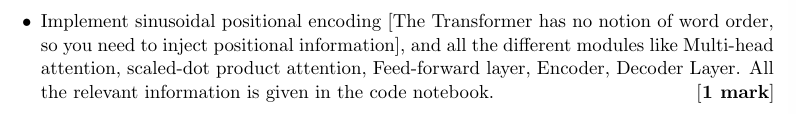

In [ ]:
from tqdm import trange


class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 5000):
        super().__init__()
        self.d_model = d_model
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)

        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)


        pe = pe.unsqueeze(0)


        self.register_buffer('pe', pe)


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        seq_len = x.size(1)
        pe = self.pe[:, :seq_len, :].to(dtype=x.dtype, device=x.device)
        return x + pe


class MultiHeadAttention(nn.Module):
    def __init__(self, d_model: int, n_heads: int, dropout: float = 0.1):
        super().__init__()
        assert d_model % n_heads == 0

        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = d_model // n_heads

        # Linear layers to project Q, K, V
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        # Final linear layer
        self.W_o = nn.Linear(d_model, d_model)


        self.dropout = nn.Dropout(dropout)
        self.attention_weights = None

        # Store attention weights for visualization
        self.attention_weights = None

    def forward(self, query: torch.Tensor, key: torch.Tensor, value: torch.Tensor,
                mask: Optional[torch.Tensor] = None) -> torch.Tensor:
        batch_size = query.size(0)

        # Linear projections
        Q = self.W_q(query)
        K = self.W_k(key)
        V = self.W_v(value)

        # Split into multiple heads
        Q = Q.view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)
        K = K.view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)
        V = V.view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)

        attn_output, attn_weights = self.scaled_dot_product_attention(Q, K, V, mask)
        self.attention_weights = attn_weights

        # Concatenate heads
        attn_output = attn_output.transpose(1, 2).contiguous()
        attn_output = attn_output.view(batch_size, -1, self.d_model)


        # Final linear projection
        output = self.W_o(attn_output)

        return output

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        d_k = Q.size(-1)
        scores = torch.matmul(Q, K.transpose(-2,-1))/ math.sqrt(d_k)


        if mask is not None:

            mask = mask.to(dtype=torch.bool, device=scores.device)

            if mask.dim() == 2:
                mask = mask.unsqueeze(1).unsqueeze(2)
                mask = mask.expand(-1, 1, scores.size(2), -1)
            elif mask.dim() == 3:
                mask = mask.unsqueeze(1)
            scores = scores.masked_fill(~mask, float('-inf'))

        attn_weights = torch.softmax(scores, dim=-1)
        attn_weights = self.dropout(attn_weights)

        output = torch.matmul(attn_weights, V)
        return output, attn_weights

class FeedForward(nn.Module):
    def __init__(self, d_model: int, d_ff: int, dropout: float = 0.1):
        super().__init__()

        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        # TODO: Implement forward pass
        return self.fc2(self.dropout(F.relu(self.fc1(x))))

class EncoderLayer(nn.Module):
    def __init__(self, d_model: int, n_heads: int, d_ff: int, dropout: float = 0.1):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, n_heads, dropout)
        self.ffn = FeedForward(d_model, d_ff, dropout)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)




    def forward(self, x: torch.Tensor, mask: Optional[torch.Tensor] = None) -> torch.Tensor:
        # TODO: Implement encoder layer forward pass

        # Self-attention block
        attn_output = self.self_attn(x, x, x, mask)
        x = x + self.dropout(attn_output)
        x = self.norm1(x)


        # Feed-forward block
        ffn_output = self.ffn(x)
        x = x + self.dropout(ffn_output)
        x = self.norm2(x)
        return x

class DecoderLayer(nn.Module):
    def __init__(self, d_model: int, n_heads: int, d_ff: int, dropout: float = 0.1):
        super().__init__()

        # TODO: Initialize components
        self.self_attn = MultiHeadAttention(d_model, n_heads, dropout)
        self.cross_attn = MultiHeadAttention(d_model, n_heads, dropout)
        self.ffn = FeedForward(d_model, d_ff, dropout)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)


    def forward(self, x: torch.Tensor, encoder_output: torch.Tensor,
                src_mask: Optional[torch.Tensor] = None,
                tgt_mask: Optional[torch.Tensor] = None) -> torch.Tensor:
        # TODO: Implement decoder layer forward pass

        attn_output = self.self_attn(x, x, x, tgt_mask)
        x = x + self.dropout(attn_output)
        x = self.norm1(x)
        attn_output = self.cross_attn(x, encoder_output, encoder_output, src_mask)
        x = x + self.dropout(attn_output)
        x = self.norm2(x)
        ffn_output = self.ffn(x)
        x = x + self.dropout(ffn_output)
        x = self.norm3(x)

        return x

class Encoder(nn.Module):
    def __init__(self, n_layers: int, d_model: int, n_heads: int,
                 d_ff: int, dropout: float = 0.1):
        super().__init__()

        # TODO: Create stack of encoder layers with normalization
        self.layers = nn.ModuleList([EncoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(n_layers)])
        self.norm = nn.LayerNorm(d_model)


    def forward(self, x: torch.Tensor, mask: Optional[torch.Tensor] = None) -> torch.Tensor:
        # TODO: Pass input through all encoder layers
        for layer in self.layers:
            x = layer(x, mask)

        return self.norm(x)

class Decoder(nn.Module):
    def __init__(self, n_layers: int, d_model: int, n_heads: int,
                 d_ff: int, dropout: float = 0.1):
        super().__init__()

        # TODO: Create stack of decoder layers with normlaization
        self.layers = nn.ModuleList([DecoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(n_layers)])
        self.norm = nn.LayerNorm(d_model)


    def forward(self, x: torch.Tensor, encoder_output: torch.Tensor,
                src_mask: Optional[torch.Tensor] = None,
                tgt_mask: Optional[torch.Tensor] = None) -> torch.Tensor:

        # TODO: Pass input through all decoder layers
        for layer in self.layers:
            x = layer(x, encoder_output, src_mask, tgt_mask)

        return self.norm(x)


## PART - 1(B)

Implement a Tiny Transformer with the following specifications:

    - Embedding dimension: 128

    - Transformer Layers 2

    - Configurable number of attention heads (1,2,4..8 etc)

    - Feed-Forward dim: 512

    - Max-Token Seq Length: 128

## Solution 1(B)

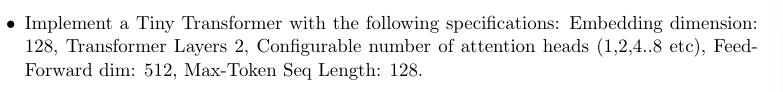

In [ ]:
class TinyTransformer(nn.Module):
    def __init__(self, src_vocab_size: int, tgt_vocab_size: int,
                 d_model: int = 128, n_heads: int = 4, n_layers: int = 2,
                 d_ff: int = 512, max_seq_len: int = 128, dropout: float = 0.1):
        super().__init__()

        # Model parameters
        self.d_model = d_model
        self.n_heads = n_heads

        # TODO: Initialize all components
        # Embeddings
        self.src_embed = nn.Embedding(src_vocab_size, d_model)
        self.tgt_embed = nn.Embedding(tgt_vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_seq_len)


        # Encoder and Decoder stacks
        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)


        # Output projection
        self.output_proj = nn.Linear(d_model, tgt_vocab_size)


        # Dropout
        self.dropout = nn.Dropout(dropout)

        self._init_parameters()

    def _init_parameters(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def create_src_mask(self, src: torch.Tensor) -> torch.Tensor:
        return (src != PAD_IDX).unsqueeze(1).unsqueeze(2)

    def create_tgt_mask(self, tgt: torch.Tensor) -> torch.Tensor:
        batch_size, tgt_len = tgt.shape


        pad_mask = (tgt != PAD_IDX).unsqueeze(1).unsqueeze(2)

        # Create causal mask: lower triangular (True in lower triangle)
        causal_mask = torch.tril(
            torch.ones(tgt_len, tgt_len, dtype=torch.bool, device=tgt.device)
        ).unsqueeze(0).unsqueeze(1)

        return pad_mask & causal_mask

    def encode(self, src: torch.Tensor, src_mask: torch.Tensor) -> torch.Tensor:
        # TODO: Implement encoding
        # 1. Embed source tokens
        x = self.src_embed(src)

        # 2. Scale embeddings by sqrt(d_model)
        x = x * math.sqrt(self.d_model)
        # 2. Add positional encoding
        x = self.pos_encoding(x)
        # 3. Add positional encoding
        # 4. Apply dropout
        x = self.dropout(x)
        # 5. Pass through encoder
        x = self.encoder(x, src_mask)
        return x

    def decode(self, tgt: torch.Tensor, encoder_output: torch.Tensor,
               src_mask: torch.Tensor, tgt_mask: torch.Tensor) -> torch.Tensor:
        # TODO: Implement decoding
        x = self.tgt_embed(tgt)
        x = x * math.sqrt(self.d_model)
        x = self.pos_encoding(x)
        x = self.dropout(x)
        x = self.decoder(x, encoder_output, src_mask, tgt_mask)
        return x

    def forward(self, src: torch.Tensor, tgt: torch.Tensor) -> torch.Tensor:
        # TODO: Implement complete forward pass

        src_mask = self.create_src_mask(src)
        tgt_mask = self.create_tgt_mask(tgt)

        encoder_output = self.encode(src, src_mask)

        decoder_output = self.decode(tgt, encoder_output, src_mask, tgt_mask)
        logits = self.output_proj(decoder_output)
        return logits

    def get_attention_weights(self):
        attention_weights = {
            'encoder_self_attention': [],
            'decoder_self_attention': [],
            'decoder_cross_attention': []
        }


        for layer in self.encoder.layers:
            attn = getattr(layer.self_attn, 'attention_weights', None)
            if attn is not None:
                attention_weights['encoder_self_attention'].append(attn.detach().cpu())
            else:
                attention_weights['encoder_self_attention'].append(None)

        for layer in self.decoder.layers:
            self_attn = getattr(layer.self_attn, 'attention_weights', None)
            cross_attn = getattr(layer.cross_attn, 'attention_weights', None)

            attention_weights['decoder_self_attention'].append(
                self_attn.detach().cpu() if self_attn is not None else None
            )
            attention_weights['decoder_cross_attention'].append(
                cross_attn.detach().cpu() if cross_attn is not None else None
            )

        return attention_weights


In [ ]:
# # debugging_ subhasini
# PAD_IDX = 0
# src = torch.tensor([[5, 6, 7, 0, 0]])
# tgt = torch.tensor([[1, 2, 3, 4, 0]])

# model = TinyTransformer(src_vocab_size=10, tgt_vocab_size=10)

# src_mask = model.create_src_mask(src)
# tgt_mask = model.create_tgt_mask(tgt)

# print("Source mask shape:", src_mask.shape)
# print("Source mask:", src_mask[0,0,0].int().tolist())

# print("\nTarget mask shape:", tgt_mask.shape)
# print("Target mask for token 3:", tgt_mask[0,0,2].int().tolist())

## PART 1(C-D)

- Train multi head model (4 heads) and single head (1) model, by keeping the number of parameters same, adjust attention head dimension accordingly.

- Implement visualization for different attention types like Encoder self-attention, Decoder self-attention and Decoder cross-attention. Visualize the attentions for multi-head and single-head both for given test sentences.

## Solution 1(C-D)

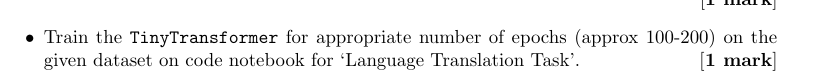

In [ ]:
from tqdm import tqdm, trange

# ============================================
# TODO: WRITE TRAINING FUNCTIONS
# ============================================

def train_epoch(model: nn.Module, dataloader: DataLoader, optimizer: optim.Optimizer,
                criterion: nn.Module, clip: float = 1.0) -> float:
    model.train()

    # TODO
    epoch_loss = 0
    for src, tgt in tqdm(dataloader,desc = "Training", leave = False):
        src, tgt = src.to(device), tgt.to(device)
        tgt_input = tgt[:, :-1]
        tgt_output = tgt[:, 1:].contiguous().view(-1)
        optimizer.zero_grad()
        output = model(src, tgt_input)
        output = output.view(-1, output.size(-1))
        loss = criterion(output, tgt_output)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(dataloader)

def evaluate(model: nn.Module, dataloader: DataLoader, criterion: nn.Module) -> float:
    model.eval()
    epoch_loss = 0

    # TODO
    with torch.no_grad():
        for src, tgt in tqdm(dataloader,desc = "Evaluating", leave = False):
            src, tgt = src.to(device), tgt.to(device)
            tgt_input = tgt[:, :-1]
            tgt_output = tgt[:, 1:].contiguous().view(-1)
            output = model(src, tgt_input)
            output = output.view(-1, output.size(-1))
            loss = criterion(output, tgt_output)
            epoch_loss += loss.item()

    return epoch_loss / len(dataloader)

# ============================================
# TODO: WRITE TRANSLATING SENTENCE FUNCTION
# ============================================

def translate_sentence(model: nn.Module, src_sentence: str, max_length: int = 128):
    model.eval()

    with torch.no_grad():
      src_ids = de_tokenizer.encode(src_sentence).ids
      src_ids = src_ids[:max_length-2]
      src_ids = [SOS_IDX] + src_ids + [EOS_IDX]
      src = torch.tensor(src_ids, dtype=torch.long, device=device).unsqueeze(0)

      generated = [SOS_IDX]

      for _ in range(max_length):
        tgt_input = torch.tensor(generated, dtype=torch.long, device=device).unsqueeze(0)
        logits = model(src, tgt_input)
        next_token = logits[0, -1].argmax(dim=-1).item()
        generated.append(next_token)
        if next_token == EOS_IDX:
          break

    out_ids = [t for t in generated[1:] if t != PAD_IDX]
    if EOS_IDX in out_ids:
      out_ids = out_ids[:out_ids.index(EOS_IDX)]
    try:
      translation = en_tokenizer.decode(out_ids)
    except:
      translation = ''
    return translation, out_ids

# ============================================
# TODO: WRITE ATTENTION VISUALIZATION FUNCTION
# ============================================

def _ids_to_tokens(tokenizer, ids):
    toks = []
    for i in ids:
        if i in (PAD_IDX,):
            continue
        tok = tokenizer.id_to_token(int(i))
        toks.append(tok)
    return toks

def _plot_heatmap(mat, xticks, yticks, title):
    plt.figure(figsize=(min(12, 1 + 0.6*len(xticks)), min(10, 1 + 0.6*len(yticks))))
    plt.imshow(mat, aspect='auto')
    plt.xticks(ticks=range(len(xticks)), labels=xticks, rotation=60, ha='right')
    plt.yticks(ticks=range(len(yticks)), labels=yticks)
    plt.title(title)
    plt.xlabel('Keys')
    plt.ylabel('Queries')
    plt.colorbar()
    plt.tight_layout()
    plt.show()



# ========================================================================
# TODO: YOU CAN USE THE ATTENTION VISUALIZATION TOOLS : ADD THE PLOTS HERE
# ========================================================================

def visualize_attention(model: nn.Module, src_sentence: str, tgt_sentence: str = None):
    model.eval()

    src_ids = de_tokenizer.encode(src_sentence).ids[:98]
    src_ids = [SOS_IDX] + src_ids + [EOS_IDX]
    src = torch.tensor(src_ids, device=device).unsqueeze(0)

    if tgt_sentence is None:
      trans_text, out_ids = translate_sentence(model,src_sentence, max_length=50)
      tgt_ids = [SOS_IDX] + out_ids + [EOS_IDX]

    else:
      raw = en_tokenizer.encode(tgt_sentence).ids[:98]
      tgt_ids = [SOS_IDX] + raw + [EOS_IDX]

    tgt = torch.tensor(tgt_ids, device=device).unsqueeze(0)

    with torch.no_grad():
        _ = model(src, tgt)


    aw = model.get_attention_weights()
    src_tokens = _ids_to_tokens(de_tokenizer, src_ids)
    tgt_tokens = _ids_to_tokens(en_tokenizer, tgt_ids)

    layer_idx = 0

    # TODO: Implement visualization for different attention types
    # 1. Encoder self-attention

    enc_list = aw['encoder_self_attention']
    if enc_list and enc_list[layer_idx] is not None:
        A = enc_list[layer_idx][0]
        for h in range(A.size(0)):
            _plot_heatmap(A[h].cpu().numpy(),
                          xticks=src_tokens, yticks=src_tokens,
                          title=f'Encoder Self-Attention | Layer {layer_idx+1} Head {h+1}')
    # 2. Decoder self-attention
    dec_self_list = aw['decoder_self_attention']
    if dec_self_list and dec_self_list[layer_idx] is not None:
        A = dec_self_list[layer_idx][0]
        for h in range(A.size(0)):
            _plot_heatmap(A[h].cpu().numpy(),
                          xticks=tgt_tokens, yticks=tgt_tokens,
                          title=f'Decoder Self-Attention | Layer {layer_idx+1} Head {h+1}')
    # 3. Decoder cross-attention
    dec_cross_list = aw['decoder_cross_attention']
    if dec_cross_list and dec_cross_list[layer_idx] is not None:
        A = dec_cross_list[layer_idx][0]
        for h in range(A.size(0)):
            _plot_heatmap(A[h].cpu().numpy(),
                          xticks=src_tokens, yticks=tgt_tokens,
                          title=f'Decoder Cross-Attention | Layer {layer_idx+1} Head {h+1}')


# ===================================================
# TODO: WRITE ATTENTION COMPARISON PATTERNS FUNCTION
# ===================================================

def compare_attention_patterns(model_multi: nn.Module, model_single: nn.Module,
                               src_sentence: str):
    print("\n=== COMPARING MULTI-HEAD vs SINGLE-HEAD ATTENTION ===")

    trans_multi, out_ids = translate_sentence(model_multi, src_sentence)
    tgt_ids = [SOS_IDX] + out_ids + [EOS_IDX]
    src_ids = de_tokenizer.encode(src_sentence).ids[:98]
    src_ids = [SOS_IDX] + src_ids + [EOS_IDX]
    src = torch.tensor(src_ids, device=device).unsqueeze(0)
    tgt = torch.tensor(tgt_ids, device=device).unsqueeze(0)

    def get_avg_cross_attn(model):
        model.eval()
        with torch.no_grad():
            _ = model(src, tgt)
        A = model.get_attention_weights()['decoder_cross_attention'][0][0]
        A_avg = A.mean(dim=0).cpu().numpy()
        return A_avg

    A_multi = get_avg_cross_attn(model_multi)
    A_single = get_avg_cross_attn(model_single)

    src_tokens = _ids_to_tokens(de_tokenizer, src_ids)
    tgt_tokens = _ids_to_tokens(en_tokenizer, tgt_ids)

    _plot_heatmap(A_multi, src_tokens, tgt_tokens, 'Cross-Attention (Avg over Heads) — Multi-Head')
    _plot_heatmap(A_single, src_tokens, tgt_tokens, 'Cross-Attention — Single-Head')




# ============================================
# TODO: WRITE MAIN TRAINING SCRIPT
# ============================================

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
# Model configurations
MODEL_CONFIGS = {
    'multi_head': {
        'd_model': 128,
        'n_heads': 4,
        'n_layers': 2,
        'd_ff': 512,
        'dropout': 0.1
    },
    'single_head': {
        'd_model': 128,
        'n_heads': 1,
        'n_layers': 2,
        'd_ff': 512,
        'dropout': 0.1
    }
}

# Initialize models
print("Initializing models...")

model_multi = TinyTransformer(
    src_vocab_size=len(de_vocab),
    tgt_vocab_size=len(en_vocab),
    **MODEL_CONFIGS['multi_head']
).to(device)

model_single = TinyTransformer(
    src_vocab_size=len(de_vocab),
    tgt_vocab_size=len(en_vocab),
    **MODEL_CONFIGS['single_head']
).to(device)

print(f"Multi-head model parameters: {count_parameters(model_multi):,}")
print(f"Single-head model parameters: {count_parameters(model_single):,}")

# Training settings
LEARNING_RATE = 5e-5
N_EPOCHS = 10 # TODO

# Loss function - ignore padding token
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)


Initializing models...
Multi-head model parameters: 4,776,208
Single-head model parameters: 4,776,208


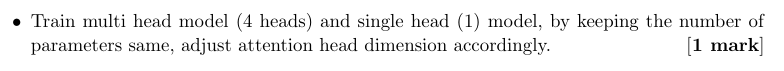

In [ ]:
# ============================================
# TRAINING LOOP FOR MULTI-HEAD MODEL
# ============================================

print("\n" + "="*50)
print("TRAINING MULTI-HEAD MODEL (4 heads)")
print("="*50)

optimizer_multi = optim.Adam(model_multi.parameters(), lr=LEARNING_RATE)

# Training history
train_losses_multi = []
val_losses_multi = []

best_val_loss = float('inf')

for epoch in trange(N_EPOCHS, desc="Epochs"):
    start_time = time.time()

    # Train
    train_loss = train_epoch(model_multi, train_loader, optimizer_multi, criterion)

    # Evaluate
    val_loss = evaluate(model_multi, val_loader, criterion)

    end_time = time.time()
    epoch_mins, epoch_secs = divmod(end_time - start_time, 60)

    train_losses_multi.append(train_loss)
    val_losses_multi.append(val_loss)


    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model_multi.state_dict(), 'tiny_transformer_multi.pt')

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins:.0f}m {epoch_secs:.0f}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Val Loss: {val_loss:.3f}')


model_multi.load_state_dict(torch.load('tiny_transformer_multi.pt'))


TRAINING MULTI-HEAD MODEL (4 heads)


Training: 100%|█████████▉| 545/547 [00:29<00:00, 20.51it/s]
                                                           
Epochs:  10%|█         | 1/10 [00:31<04:41, 31.33s/it]

Epoch: 01 | Time: 0m 31s
	Train Loss: 7.486 | Val Loss: 6.357



Training: 100%|█████████▉| 546/547 [00:27<00:00, 17.93it/s]
                                                           
Epochs:  20%|██        | 2/10 [01:00<04:00, 30.11s/it]

Epoch: 02 | Time: 0m 29s
	Train Loss: 6.140 | Val Loss: 5.874



Training: 100%|█████████▉| 545/547 [00:27<00:00, 20.30it/s]
                                                           
Epochs:  30%|███       | 3/10 [01:29<03:25, 29.38s/it]

Epoch: 03 | Time: 0m 28s
	Train Loss: 5.634 | Val Loss: 5.556



Training: 100%|█████████▉| 546/547 [00:27<00:00, 19.59it/s]
                                                           
Epochs:  40%|████      | 4/10 [01:57<02:54, 29.09s/it]

Epoch: 04 | Time: 0m 29s
	Train Loss: 5.290 | Val Loss: 5.387



Training: 100%|█████████▉| 546/547 [00:27<00:00, 20.97it/s]
                                                           
Epochs:  50%|█████     | 5/10 [02:26<02:24, 28.97s/it]

Epoch: 05 | Time: 0m 29s
	Train Loss: 5.077 | Val Loss: 5.252



Training: 100%|██████████| 547/547 [00:27<00:00, 18.70it/s]
                                                           
Epochs:  60%|██████    | 6/10 [02:55<01:56, 29.14s/it]

Epoch: 06 | Time: 0m 29s
	Train Loss: 4.930 | Val Loss: 5.147



Training: 100%|██████████| 547/547 [00:27<00:00, 21.84it/s]
                                                           
Epochs:  70%|███████   | 7/10 [03:25<01:27, 29.22s/it]

Epoch: 07 | Time: 0m 29s
	Train Loss: 4.812 | Val Loss: 5.050



Training: 100%|██████████| 547/547 [00:27<00:00, 20.62it/s]
                                                           
Epochs:  80%|████████  | 8/10 [03:54<00:58, 29.20s/it]

Epoch: 08 | Time: 0m 29s
	Train Loss: 4.708 | Val Loss: 4.964



Training: 100%|█████████▉| 545/547 [00:27<00:00, 21.04it/s]
                                                           
Epochs:  90%|█████████ | 9/10 [04:24<00:29, 29.39s/it]

Epoch: 09 | Time: 0m 30s
	Train Loss: 4.619 | Val Loss: 4.920



Training: 100%|█████████▉| 545/547 [00:27<00:00, 19.86it/s]
                                                           
Epochs: 100%|██████████| 10/10 [04:53<00:00, 29.37s/it]

Epoch: 10 | Time: 0m 29s
	Train Loss: 4.539 | Val Loss: 4.867


<All keys matched successfully>

In [ ]:
# ============================================
# TODO: TRAINING LOOP FOR SINGLE-HEAD MODEL
# ============================================



print("\n" + "="*50)
print("TRAINING SINGLE-HEAD MODEL")
print("="*50)

optimizer_single = optim.Adam(model_single.parameters(), lr=LEARNING_RATE)

# Training history
train_losses_single = []
val_losses_single = []

best_val_loss = float('inf')

for epoch in trange(N_EPOCHS):
    start_time = time.time()

    # Train
    train_loss = train_epoch(model_single, train_loader, optimizer_single, criterion)


    # Evaluate
    val_loss = evaluate(model_single, val_loader, criterion)

    end_time = time.time()
    epoch_mins, epoch_secs = divmod(end_time - start_time, 60)

    train_losses_single.append(train_loss)
    val_losses_single.append(val_loss)

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model_single.state_dict(), 'tiny_transformer_single.pt')


    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins:.0f}m {epoch_secs:.0f}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Val Loss: {val_loss:.3f}')

# Load best model
# TODO
model_single.load_state_dict(torch.load('tiny_transformer_single.pt'))




TRAINING SINGLE-HEAD MODEL


Training: 100%|██████████| 547/547 [00:24<00:00, 23.41it/s]
                                                           
 10%|█         | 1/10 [00:25<03:51, 25.68s/it]

Epoch: 01 | Time: 0m 26s
	Train Loss: 7.514 | Val Loss: 6.391



Training: 100%|█████████▉| 546/547 [00:24<00:00, 23.37it/s]
                                                           
 20%|██        | 2/10 [00:51<03:24, 25.62s/it]

Epoch: 02 | Time: 0m 26s
	Train Loss: 6.138 | Val Loss: 5.876



Training: 100%|██████████| 547/547 [00:24<00:00, 25.75it/s]
                                                           
 30%|███       | 3/10 [01:16<02:59, 25.62s/it]

Epoch: 03 | Time: 0m 26s
	Train Loss: 5.621 | Val Loss: 5.542



Training: 100%|█████████▉| 546/547 [00:24<00:00, 24.34it/s]
                                                           
 40%|████      | 4/10 [01:42<02:34, 25.77s/it]

Epoch: 04 | Time: 0m 26s
	Train Loss: 5.270 | Val Loss: 5.349



Training: 100%|█████████▉| 546/547 [00:24<00:00, 23.79it/s]
                                                           
 50%|█████     | 5/10 [02:08<02:09, 25.86s/it]

Epoch: 05 | Time: 0m 26s
	Train Loss: 5.061 | Val Loss: 5.220



Training: 100%|██████████| 547/547 [00:24<00:00, 24.03it/s]
                                                           
 60%|██████    | 6/10 [02:35<01:43, 25.95s/it]

Epoch: 06 | Time: 0m 26s
	Train Loss: 4.913 | Val Loss: 5.108



Training: 100%|█████████▉| 545/547 [00:24<00:00, 23.46it/s]
                                                           
 70%|███████   | 7/10 [03:01<01:18, 26.01s/it]

Epoch: 07 | Time: 0m 26s
	Train Loss: 4.792 | Val Loss: 5.019



Training: 100%|█████████▉| 546/547 [00:24<00:00, 23.11it/s]
                                                           
 80%|████████  | 8/10 [03:27<00:52, 26.06s/it]

Epoch: 08 | Time: 0m 26s
	Train Loss: 4.690 | Val Loss: 4.933



Training: 100%|█████████▉| 546/547 [00:24<00:00, 24.04it/s]
                                                           
 90%|█████████ | 9/10 [03:53<00:26, 26.13s/it]

Epoch: 09 | Time: 0m 26s
	Train Loss: 4.601 | Val Loss: 4.891



Training: 100%|█████████▉| 546/547 [00:24<00:00, 23.43it/s]
                                                           
100%|██████████| 10/10 [04:19<00:00, 25.97s/it]


Epoch: 10 | Time: 0m 26s
	Train Loss: 4.520 | Val Loss: 4.825


<All keys matched successfully>

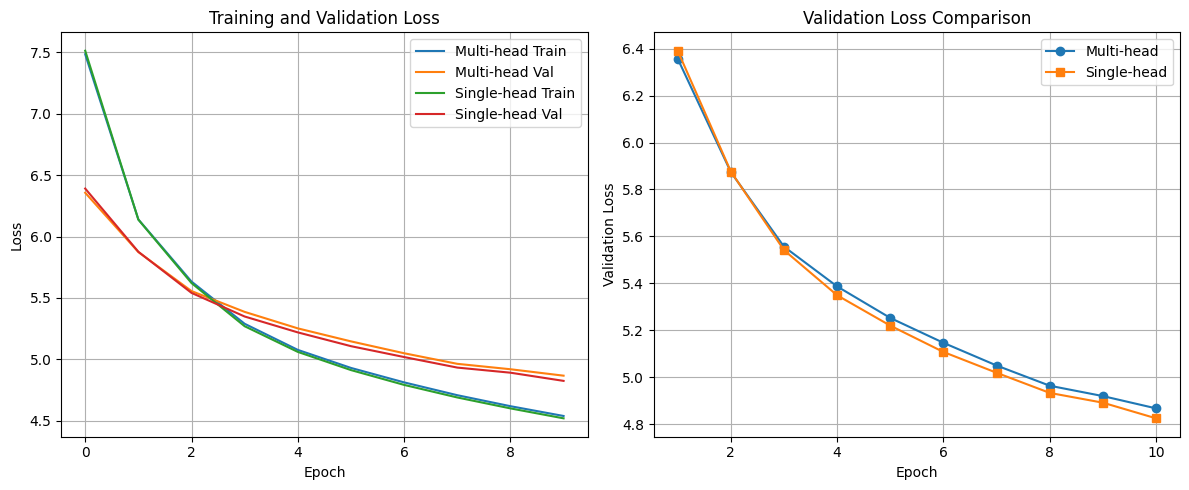

In [ ]:
# ============================================
# TODO: PLOT TRAINING CURVES
# ============================================

plt.figure(figsize=(12, 5))

# Loss curves
plt.subplot(1, 2, 1)
plt.plot(train_losses_multi, label='Multi-head Train')
plt.plot(val_losses_multi, label='Multi-head Val')
plt.plot(train_losses_single, label='Single-head Train')
plt.plot(val_losses_single, label='Single-head Val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# Validation loss comparison
plt.subplot(1, 2, 2)
epochs = range(1, N_EPOCHS + 1)
plt.plot(epochs, val_losses_multi, 'o-', label='Multi-head')
plt.plot(epochs, val_losses_single, 's-', label='Single-head')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss Comparison')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# ============================================
# TODO: EVALUATION AND VISUALIZATION
# ============================================

print("\n" + "="*50)
print("EVALUATION ON TEST SENTENCES")
print("="*50)

# Test sentences
test_sentences = [
    "Ein Mann läuft auf der Straße.",  # A man walks on the street
    "Die Katze sitzt auf dem Tisch.",   # The cat sits on the table
    "Ich liebe dich.",                  # I love you
    "Das Wetter ist heute schön.",      # The weather is nice today
    "Können Sie mir helfen?"            # Can you help me?
]

print("\nTranslation Examples:")
for i, src in enumerate(test_sentences):
    print(f"\n{i+1}. Source: {src}")

    trans_multi, _ = translate_sentence(model_multi, src)
    print(f"   Multi-head: {trans_multi}")

    trans_single, _ = translate_sentence(model_single, src)
    print(f"   Single-head: {trans_single}")



EVALUATION ON TEST SENTENCES

Translation Examples:

1. Source: Ein Mann läuft auf der Straße.
   Multi-head: The same time is the same .
   Single-head: The of the of the .

2. Source: Die Katze sitzt auf dem Tisch.
   Multi-head: The of the same report .
   Single-head: The of the of the .

3. Source: Ich liebe dich.
   Multi-head: I am very very very .
   Single-head: I am not to say .

4. Source: Das Wetter ist heute schön.
   Multi-head: The debate is a .
   Single-head: The is a .

5. Source: Können Sie mir helfen?
   Multi-head: I would like to say that we have to be ?
   Single-head: I am not to say ?


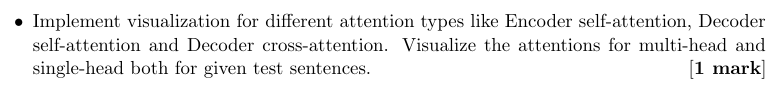


ATTENTION VISUALIZATION

Visualizing attention for: 'Die Katze sitzt auf dem Tisch.'

### MULTI-HEAD MODEL ###


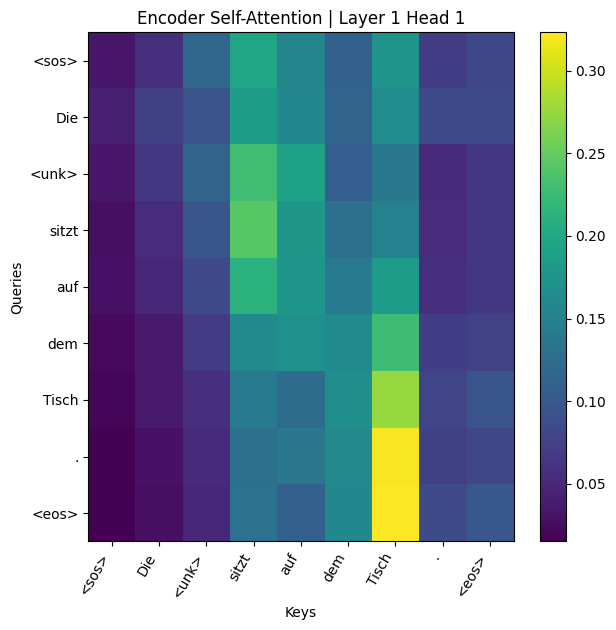

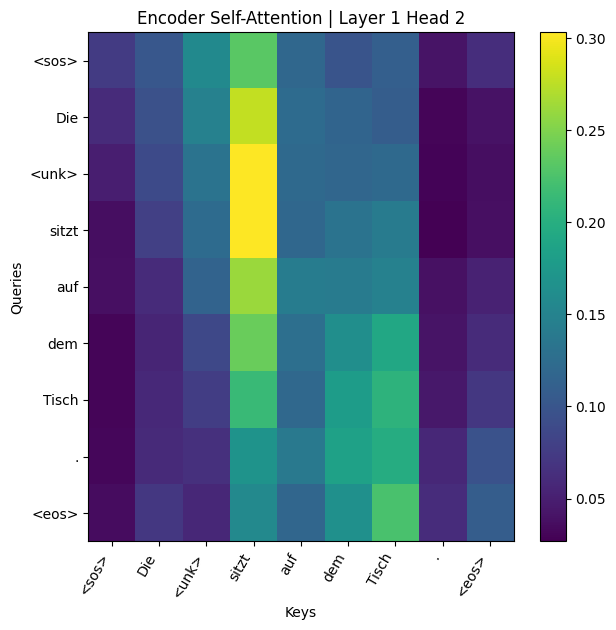

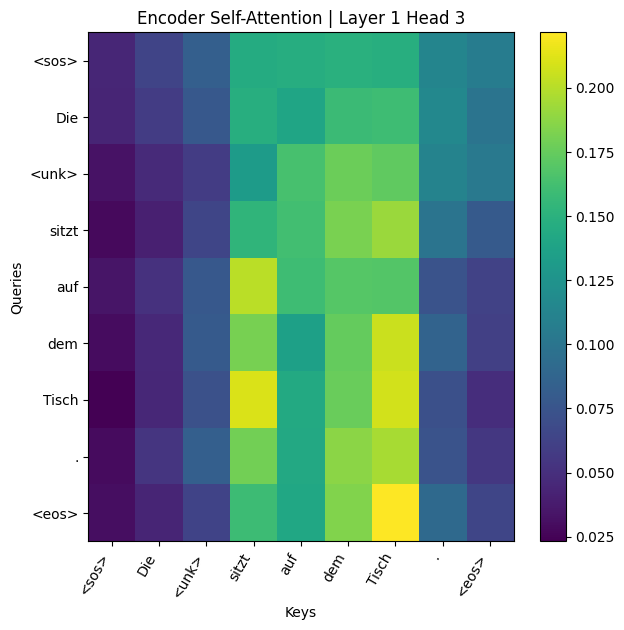

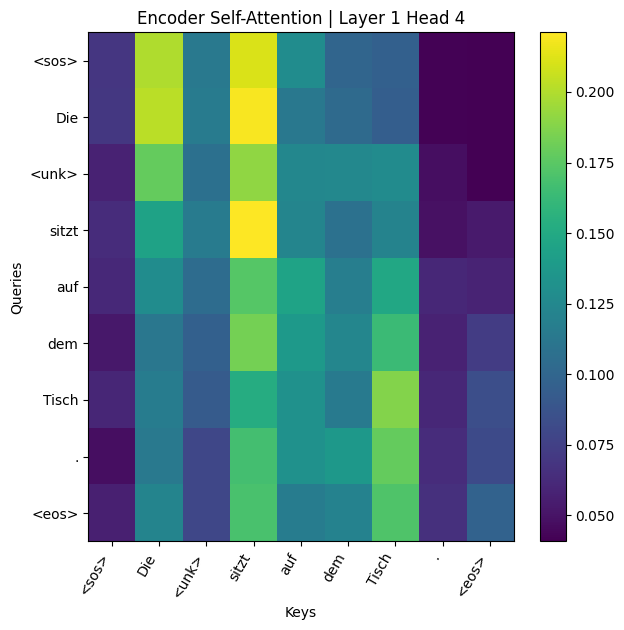

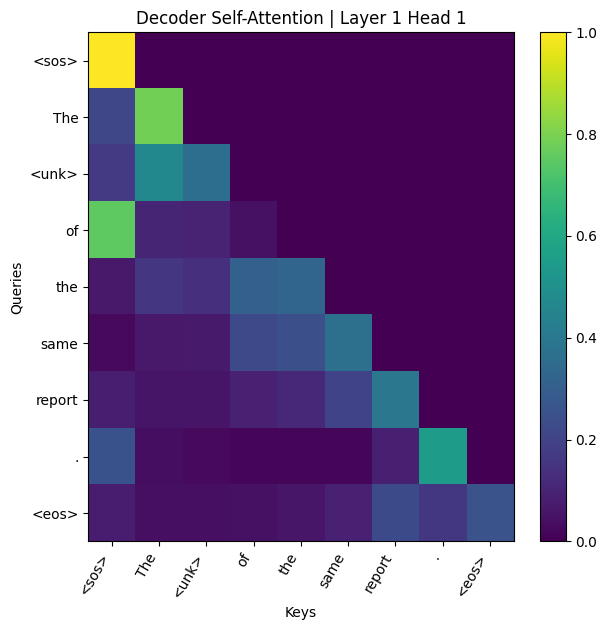

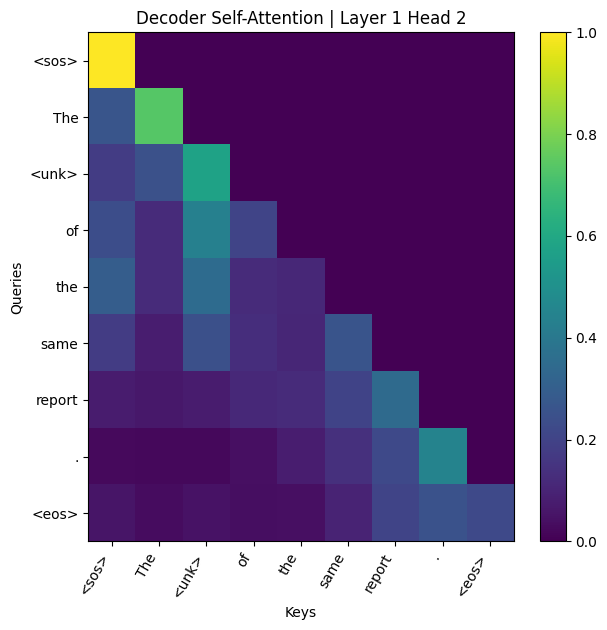

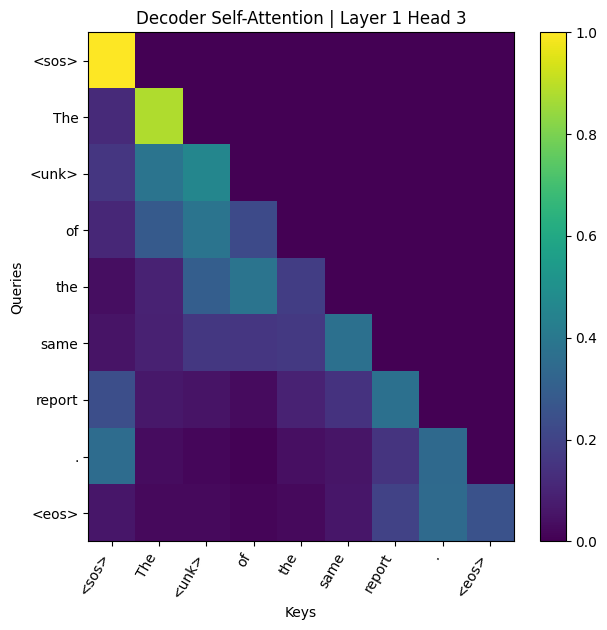

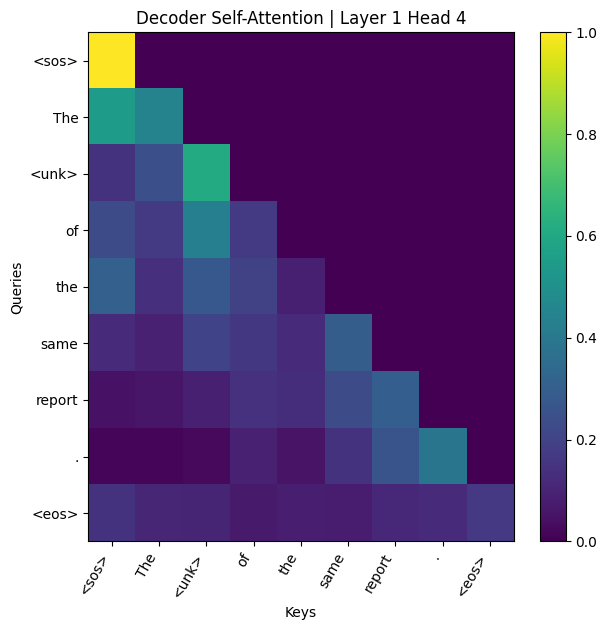

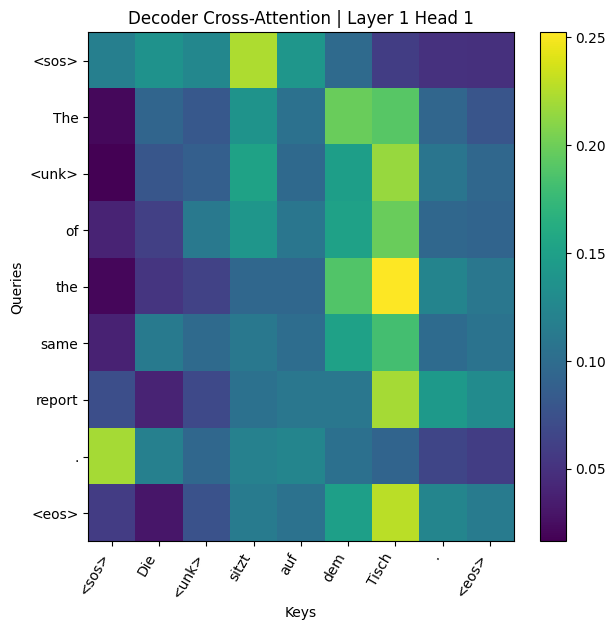

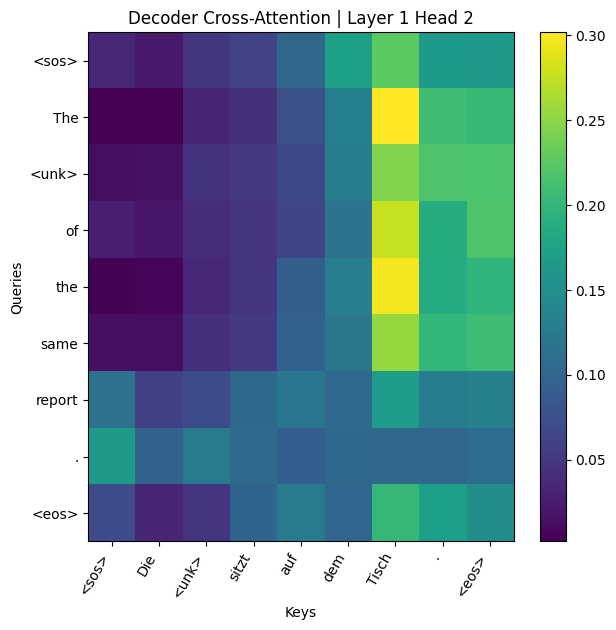

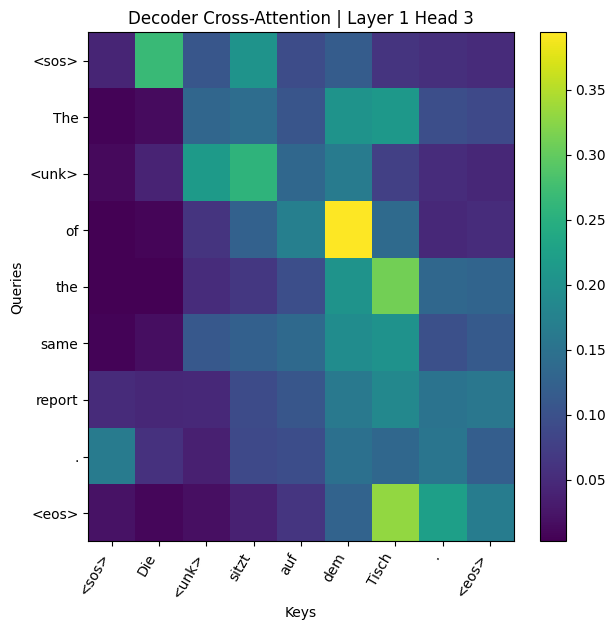

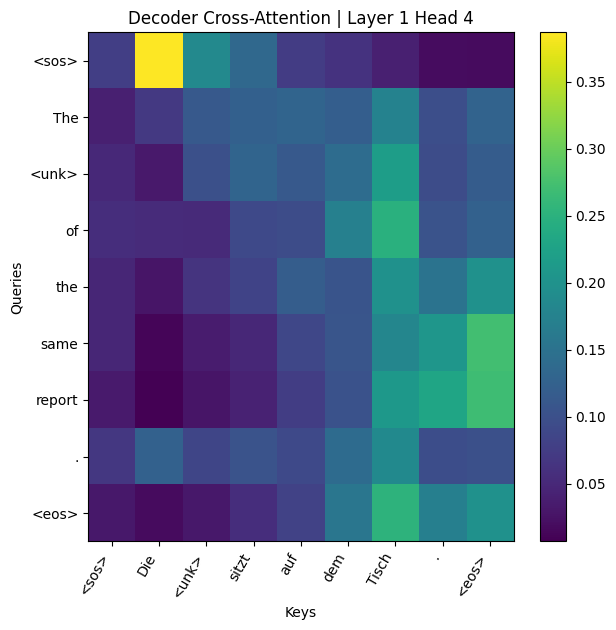


### SINGLE-HEAD MODEL ###


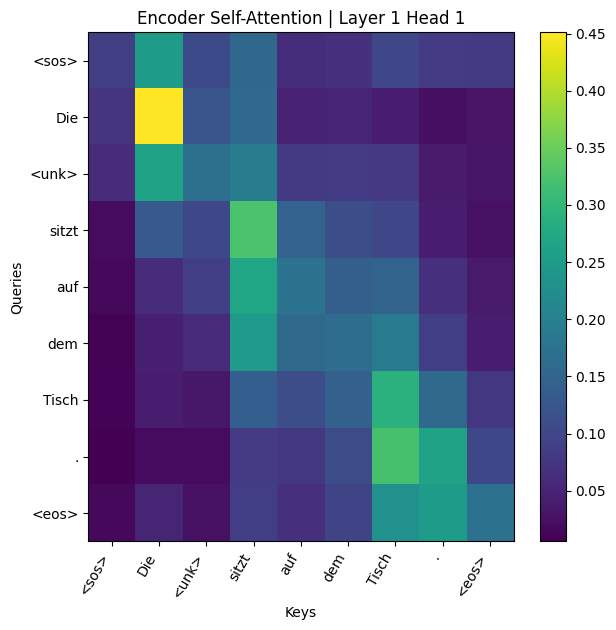

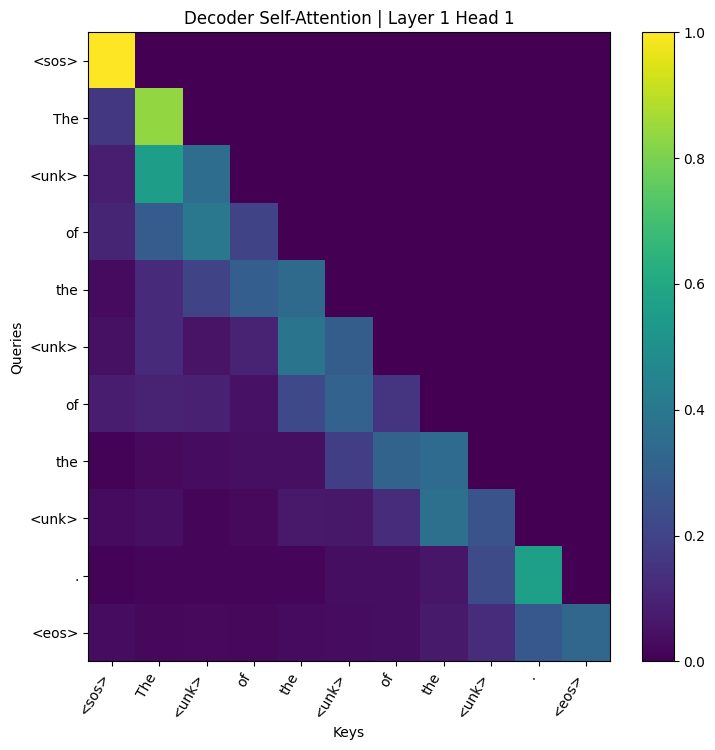

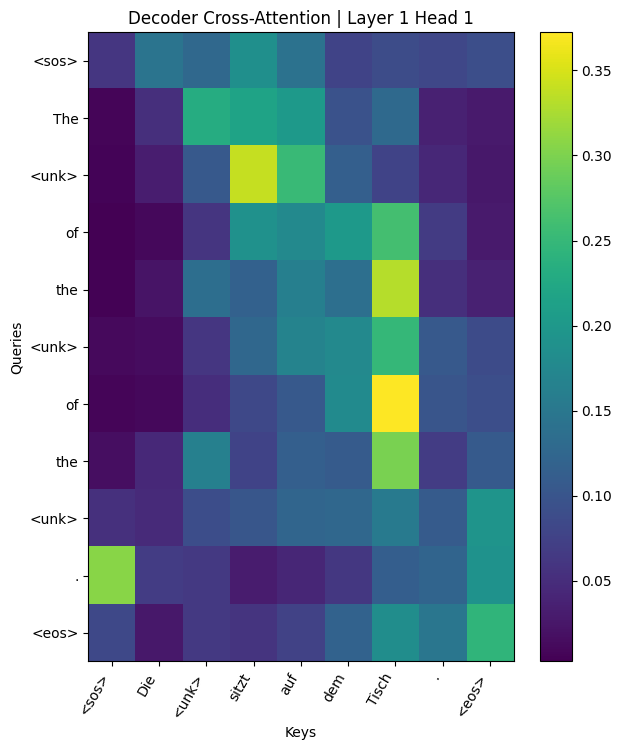


=== COMPARING MULTI-HEAD vs SINGLE-HEAD ATTENTION ===


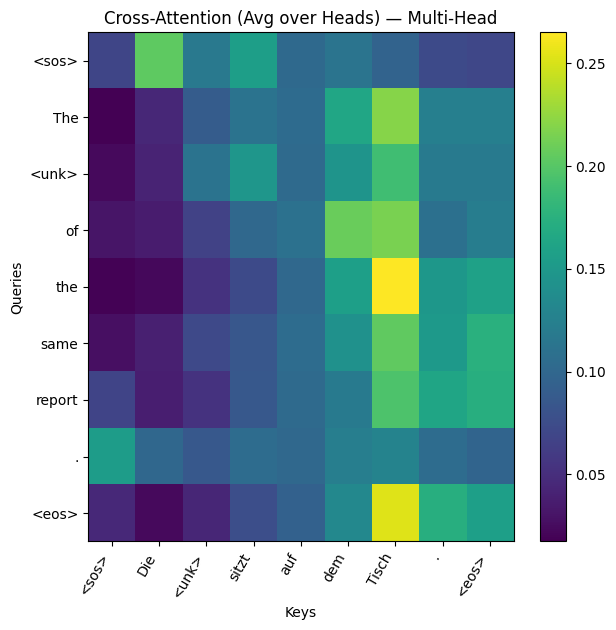

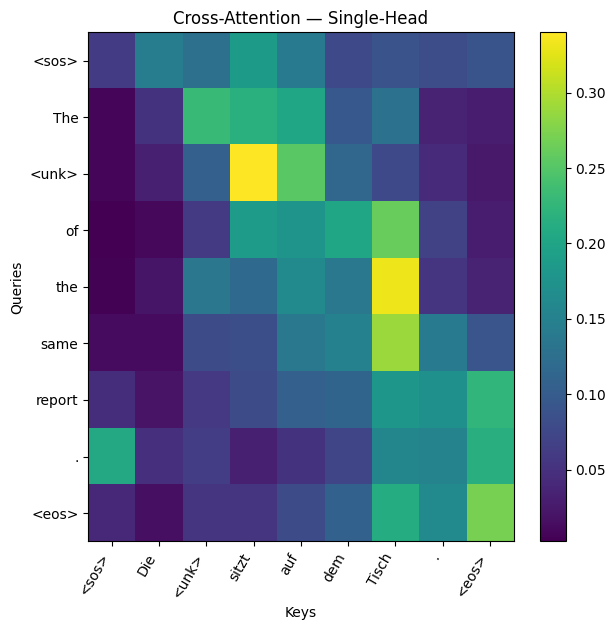

In [ ]:
# ============================================
# ATTENTION VISUALIZATION FOR TEST SENTENCE
# ============================================

print("\n" + "="*50)
print("ATTENTION VISUALIZATION")
print("="*50)


test_sentence = "Die Katze sitzt auf dem Tisch."
print(f"\nVisualizing attention for: '{test_sentence}'")

print("\n### MULTI-HEAD MODEL ###")
visualize_attention(model_multi, test_sentence)


print("\n### SINGLE-HEAD MODEL ###")
visualize_attention(model_single, test_sentence)


compare_attention_patterns(model_multi, model_single, test_sentence)

**OBSERVATION**


In the multi-head model, attention is spread across different heads, capturing diverse word alignments and long-range dependencies.

In the single-head model, attention is more concentrated, often focusing strongly on a compartively fewer tokens.

Thus, multi-head shows richer and more distributed patterns, while single-head is less expressive.

# PART: 2 - Architecture Ablation Study


## PART 2(A)

**Study the Role of Residual Connections**

## Solution 2(A)

In [ ]:
# =========================================================================================================================
# TODO: ARCHITECTURAL ABLATION STUDIES [YOU MAY CHOOSE DIFFERENT IMPLEMENTATION STRATEGY AS LONG AS YOU IMPLEMENT AS ASKED]
# =========================================================================================================================

# --- Experiment 1: Removing Residual Connections ---

import torch
import torch.nn as nn
import math
from typing import Optional


class EncoderLayerNoResidual(nn.Module):
    def __init__(self, d_model: int, n_heads: int, d_ff: int, dropout: float = 0.1):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, n_heads, dropout)
        self.ffn = FeedForward(d_model, d_ff, dropout)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor, mask: Optional[torch.Tensor] = None) -> torch.Tensor:
        attn_output = self.self_attn(x, x, x, mask)
        x = self.norm1(self.dropout(attn_output))

        ffn_output = self.ffn(x)
        x = self.norm2(self.dropout(ffn_output))

        return x


class DecoderLayerNoResidual(nn.Module):
    def __init__(self, d_model: int, n_heads: int, d_ff: int, dropout: float = 0.1):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, n_heads, dropout)
        self.cross_attn = MultiHeadAttention(d_model, n_heads, dropout)
        self.ffn = FeedForward(d_model, d_ff, dropout)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor, encoder_output: torch.Tensor,
                src_mask: Optional[torch.Tensor] = None,
                tgt_mask: Optional[torch.Tensor] = None) -> torch.Tensor:
        attn_output = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(self.dropout(attn_output))

        attn_output = self.cross_attn(x, encoder_output, encoder_output, src_mask)
        x = self.norm2(self.dropout(attn_output))

        ffn_output = self.ffn(x)
        x = self.norm3(self.dropout(ffn_output))

        return x


class EncoderNoResidual(nn.Module):
    def __init__(self, n_layers: int, d_model: int, n_heads: int,
                 d_ff: int, dropout: float = 0.1):
        super().__init__()
        self.layers = nn.ModuleList([
            EncoderLayerNoResidual(d_model, n_heads, d_ff, dropout)
            for _ in range(n_layers)
        ])
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x: torch.Tensor, mask: Optional[torch.Tensor] = None) -> torch.Tensor:
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)


class DecoderNoResidual(nn.Module):
    def __init__(self, n_layers: int, d_model: int, n_heads: int,
                 d_ff: int, dropout: float = 0.1):
        super().__init__()
        self.layers = nn.ModuleList([
            DecoderLayerNoResidual(d_model, n_heads, d_ff, dropout)
            for _ in range(n_layers)
        ])
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x: torch.Tensor, encoder_output: torch.Tensor,
                src_mask: Optional[torch.Tensor] = None,
                tgt_mask: Optional[torch.Tensor] = None) -> torch.Tensor:
        for layer in self.layers:
            x = layer(x, encoder_output, src_mask, tgt_mask)
        return self.norm(x)



class TransformerNoResidual(nn.Module):
    def __init__(self, src_vocab_size: int, tgt_vocab_size: int,
                 d_model: int = 128, n_heads: int = 4, n_layers: int = 2,
                 d_ff: int = 512, max_seq_len: int = 128, dropout: float = 0.1):
        super().__init__()

        self.d_model = d_model
        self.n_heads = n_heads


        self.src_embed = nn.Embedding(src_vocab_size, d_model)
        self.tgt_embed = nn.Embedding(tgt_vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_seq_len)
        self.encoder = EncoderNoResidual(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = DecoderNoResidual(n_layers, d_model, n_heads, d_ff, dropout)
        self.output_proj = nn.Linear(d_model, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)
        self._init_parameters()

    def _init_parameters(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def create_src_mask(self, src: torch.Tensor) -> torch.Tensor:
        return (src != PAD_IDX).unsqueeze(1).unsqueeze(2)

    def create_tgt_mask(self, tgt: torch.Tensor) -> torch.Tensor:
        batch_size, tgt_len = tgt.shape
        pad_mask = (tgt != PAD_IDX).unsqueeze(1).unsqueeze(2)
        causal_mask = torch.tril(
            torch.ones(tgt_len, tgt_len, dtype=torch.bool, device=tgt.device)
        ).unsqueeze(0).unsqueeze(1)
        return pad_mask & causal_mask

    def encode(self, src: torch.Tensor, src_mask: torch.Tensor) -> torch.Tensor:
        x = self.src_embed(src)
        x = x * math.sqrt(self.d_model)
        x = self.pos_encoding(x)
        x = self.dropout(x)
        x = self.encoder(x, src_mask)
        return x

    def decode(self, tgt: torch.Tensor, encoder_output: torch.Tensor,
               src_mask: torch.Tensor, tgt_mask: torch.Tensor) -> torch.Tensor:
        x = self.tgt_embed(tgt)
        x = x * math.sqrt(self.d_model)
        x = self.pos_encoding(x)
        x = self.dropout(x)
        x = self.decoder(x, encoder_output, src_mask, tgt_mask)
        return x

    def forward(self, src: torch.Tensor, tgt: torch.Tensor) -> torch.Tensor:
        src_mask = self.create_src_mask(src)
        tgt_mask = self.create_tgt_mask(tgt)
        encoder_output = self.encode(src, src_mask)
        decoder_output = self.decode(tgt, encoder_output, src_mask, tgt_mask)
        logits = self.output_proj(decoder_output)
        return logits

# TODO -- RUN TRAINING

In [ ]:
MAX_SEQ_LEN = 128

In [ ]:
model_no_residual = TransformerNoResidual(
    src_vocab_size=len(de_vocab),
    tgt_vocab_size=len(en_vocab),
    max_seq_len=MAX_SEQ_LEN,
    **MODEL_CONFIGS['multi_head']
).to(device)

model_no_residual_single = TransformerNoResidual(
    src_vocab_size=len(de_vocab),
    tgt_vocab_size=len(en_vocab),
    max_seq_len=MAX_SEQ_LEN,
    **MODEL_CONFIGS['single_head']
).to(device)

In [ ]:


# ============================================
# TRAINING LOOP FOR NO-RESIDUAL MODEL
# ============================================

print("\n" + "="*50)
print("TRAINING NO-RESIDUAL MODEL (4 heads)")
print("="*50)

optimizer_no_residual = optim.Adam(model_no_residual.parameters(), lr=LEARNING_RATE)

# Training history
train_losses_nores = []
val_losses_nores = []

best_val_loss = float('inf')

for epoch in trange(N_EPOCHS, desc="Epochs"):
    start_time = time.time()

    # Train
    train_loss = train_epoch(model_no_residual, train_loader, optimizer_no_residual, criterion)

    # Evaluate
    val_loss = evaluate(model_no_residual, val_loader, criterion)

    end_time = time.time()
    epoch_mins, epoch_secs = divmod(end_time - start_time, 60)

    train_losses_nores.append(train_loss)
    val_losses_nores.append(val_loss)

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model_no_residual.state_dict(), 'tiny_transformer_nores_multi.pt')

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins:.0f}m {epoch_secs:.0f}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Val Loss: {val_loss:.3f}')

model_no_residual.load_state_dict(torch.load('tiny_transformer_nores_multi.pt'))



TRAINING NO-RESIDUAL MODEL (4 heads)


Training: 100%|█████████▉| 545/547 [00:26<00:00, 23.08it/s]
                                                           
Epochs:  10%|█         | 1/10 [00:27<04:11, 27.89s/it]

Epoch: 01 | Time: 0m 28s
	Train Loss: 7.550 | Val Loss: 6.380



Training: 100%|██████████| 547/547 [00:26<00:00, 21.69it/s]
                                                           
Epochs:  20%|██        | 2/10 [00:56<03:44, 28.10s/it]

Epoch: 02 | Time: 0m 28s
	Train Loss: 6.317 | Val Loss: 6.228



Training: 100%|█████████▉| 546/547 [00:26<00:00, 21.87it/s]
                                                           
Epochs:  30%|███       | 3/10 [01:24<03:16, 28.09s/it]

Epoch: 03 | Time: 0m 28s
	Train Loss: 6.252 | Val Loss: 6.168



Training: 100%|██████████| 547/547 [00:26<00:00, 20.93it/s]
                                                           
Epochs:  40%|████      | 4/10 [01:52<02:49, 28.31s/it]

Epoch: 04 | Time: 0m 29s
	Train Loss: 6.135 | Val Loss: 6.136



Training: 100%|█████████▉| 545/547 [00:27<00:00, 21.38it/s]
                                                           
Epochs:  50%|█████     | 5/10 [02:21<02:21, 28.37s/it]

Epoch: 05 | Time: 0m 28s
	Train Loss: 5.922 | Val Loss: 6.168



Training: 100%|██████████| 547/547 [00:27<00:00, 20.26it/s]
                                                           
Epochs:  60%|██████    | 6/10 [02:49<01:53, 28.46s/it]

Epoch: 06 | Time: 0m 29s
	Train Loss: 5.713 | Val Loss: 6.180



Training: 100%|██████████| 547/547 [00:27<00:00, 21.80it/s]
                                                           
Epochs:  70%|███████   | 7/10 [03:18<01:25, 28.42s/it]

Epoch: 07 | Time: 0m 28s
	Train Loss: 5.597 | Val Loss: 6.201



Training: 100%|██████████| 547/547 [00:27<00:00, 21.82it/s]
                                                           
Epochs:  80%|████████  | 8/10 [03:46<00:56, 28.50s/it]

Epoch: 08 | Time: 0m 29s
	Train Loss: 5.523 | Val Loss: 6.212



Training: 100%|█████████▉| 545/547 [00:27<00:00, 16.54it/s]
                                                           
Epochs:  90%|█████████ | 9/10 [04:15<00:28, 28.64s/it]

Epoch: 09 | Time: 0m 29s
	Train Loss: 5.446 | Val Loss: 6.222



Training: 100%|█████████▉| 546/547 [00:27<00:00, 21.10it/s]
                                                           
Epochs: 100%|██████████| 10/10 [04:44<00:00, 28.46s/it]

Epoch: 10 | Time: 0m 29s
	Train Loss: 5.383 | Val Loss: 6.213


<All keys matched successfully>

In [ ]:
# ============================================
# SINGLE-HEAD NO-RESIDUAL MODEL
# ============================================

model_no_residual_single = TransformerNoResidual(
    src_vocab_size=len(de_vocab),
    tgt_vocab_size=len(en_vocab),
    **MODEL_CONFIGS['single_head']
).to(device)


# ============================================
# TRAINING LOOP FOR SINGLE-HEAD MODEL
# ============================================

print("\n" + "="*50)
print("TRAINING SINGLE-HEAD MODEL")
print("="*50)

optimizer_single = optim.Adam(model_no_residual_single.parameters(), lr=LEARNING_RATE)

# Training history
train_losses_nores_single = []
val_losses_nores_single = []

best_val_loss = float('inf')

for epoch in trange(N_EPOCHS):
    start_time = time.time()

    # Train
    train_loss = train_epoch(model_no_residual_single, train_loader, optimizer_single, criterion)

    # Evaluate
    val_loss = evaluate(model_no_residual_single, val_loader, criterion)

    end_time = time.time()
    epoch_mins, epoch_secs = divmod(end_time - start_time, 60)

    train_losses_nores_single.append(train_loss)
    val_losses_nores_single.append(val_loss)

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model_no_residual_single.state_dict(), 'tiny_transformer_nores_single.pt')

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins:.0f}m {epoch_secs:.0f}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Val Loss: {val_loss:.3f}')
model_no_residual_single.load_state_dict(torch.load('tiny_transformer_nores_single.pt'))



TRAINING SINGLE-HEAD MODEL


Training: 100%|█████████▉| 546/547 [00:23<00:00, 23.24it/s]
                                                           
 10%|█         | 1/10 [00:25<03:45, 25.06s/it]

Epoch: 01 | Time: 0m 25s
	Train Loss: 7.567 | Val Loss: 6.410



Training: 100%|██████████| 547/547 [00:24<00:00, 23.69it/s]
                                                           
 20%|██        | 2/10 [00:50<03:21, 25.24s/it]

Epoch: 02 | Time: 0m 25s
	Train Loss: 6.322 | Val Loss: 6.229



Training:  99%|█████████▉| 544/547 [00:24<00:00, 24.91it/s]
                                                           
 30%|███       | 3/10 [01:15<02:56, 25.28s/it]

Epoch: 03 | Time: 0m 25s
	Train Loss: 6.230 | Val Loss: 6.250



Training: 100%|██████████| 547/547 [00:24<00:00, 23.31it/s]
                                                           
 40%|████      | 4/10 [01:41<02:32, 25.43s/it]

Epoch: 04 | Time: 0m 26s
	Train Loss: 6.123 | Val Loss: 6.181



Training: 100%|█████████▉| 546/547 [00:24<00:00, 25.09it/s]
                                                           
 50%|█████     | 5/10 [02:07<02:07, 25.54s/it]

Epoch: 05 | Time: 0m 26s
	Train Loss: 6.019 | Val Loss: 6.238



Training: 100%|█████████▉| 546/547 [00:24<00:00, 25.69it/s]
                                                           
 60%|██████    | 6/10 [02:32<01:42, 25.61s/it]

Epoch: 06 | Time: 0m 26s
	Train Loss: 5.943 | Val Loss: 6.258



Training: 100%|██████████| 547/547 [00:24<00:00, 24.30it/s]
                                                           
 70%|███████   | 7/10 [02:58<01:17, 25.68s/it]

Epoch: 07 | Time: 0m 26s
	Train Loss: 5.870 | Val Loss: 6.218



Training: 100%|█████████▉| 546/547 [00:24<00:00, 22.78it/s]
                                                           
 80%|████████  | 8/10 [03:24<00:51, 25.77s/it]

Epoch: 08 | Time: 0m 26s
	Train Loss: 5.790 | Val Loss: 6.196



Training: 100%|█████████▉| 545/547 [00:24<00:00, 23.34it/s]
                                                           
 90%|█████████ | 9/10 [03:50<00:25, 25.82s/it]

Epoch: 09 | Time: 0m 26s
	Train Loss: 5.738 | Val Loss: 6.194



Training: 100%|█████████▉| 546/547 [00:24<00:00, 23.72it/s]
                                                           
100%|██████████| 10/10 [04:16<00:00, 25.68s/it]


Epoch: 10 | Time: 0m 26s
	Train Loss: 5.701 | Val Loss: 6.177


<All keys matched successfully>

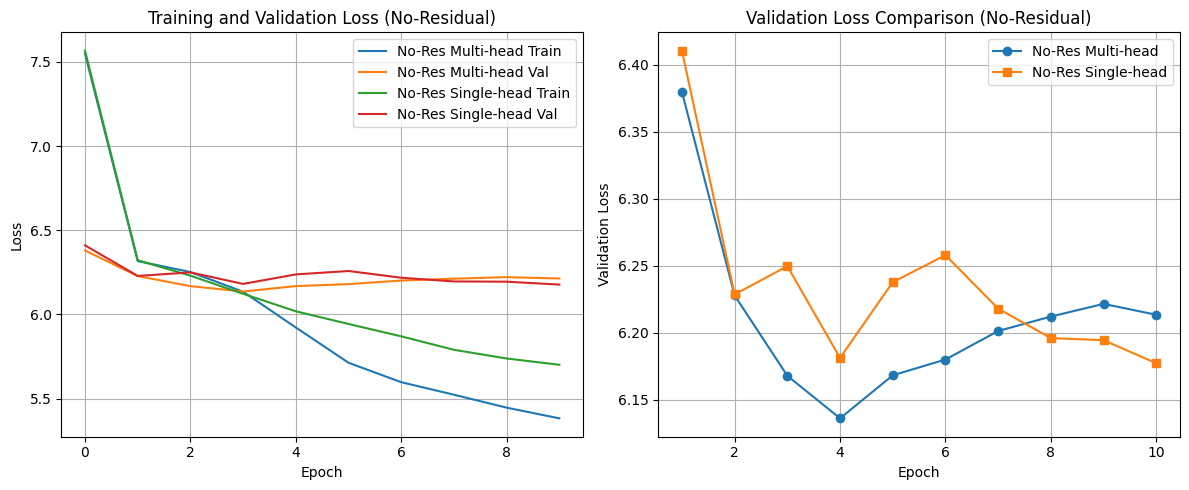

In [ ]:
# ============================================
# PLOT TRAINING CURVES
# ============================================

plt.figure(figsize=(12, 5))

# Loss curves
plt.subplot(1, 2, 1)
plt.plot(train_losses_nores, label='No-Res Multi-head Train')
plt.plot(val_losses_nores, label='No-Res Multi-head Val')
plt.plot(train_losses_nores_single, label='No-Res Single-head Train')
plt.plot(val_losses_nores_single, label='No-Res Single-head Val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (No-Residual)')
plt.legend()
plt.grid(True)


# Validation loss comparison
plt.subplot(1, 2, 2)
epochs = range(1, N_EPOCHS + 1)
plt.plot(epochs, val_losses_nores, 'o-', label='No-Res Multi-head')
plt.plot(epochs, val_losses_nores_single, 's-', label='No-Res Single-head')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss Comparison (No-Residual)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Plotting  the training and validation loss
 curves for both the baseline and the modified model on the same graph

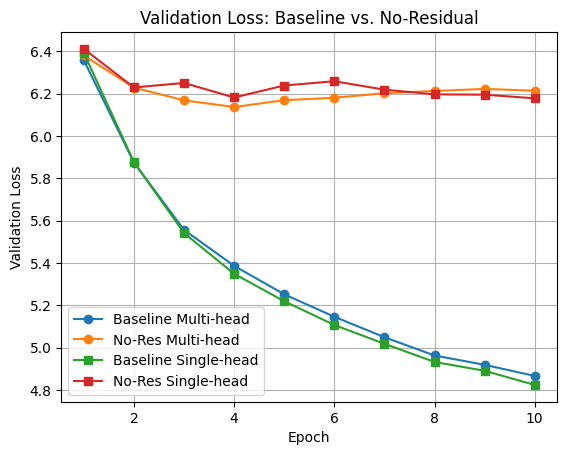

In [ ]:
# Validation loss comparison
plt.subplot(1, 1, 1)
epochs = range(1, N_EPOCHS + 1)

# Plotting baseline vs no-residual for multi-head
plt.plot(epochs, val_losses_multi, 'o-', label='Baseline Multi-head')
plt.plot(epochs, val_losses_nores, 'o-', label='No-Res Multi-head')


plt.plot(epochs, val_losses_single, 's-', label='Baseline Single-head')
plt.plot(epochs, val_losses_nores_single, 's-', label='No-Res Single-head')

plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss: Baseline vs. No-Residual')
plt.legend()
plt.grid(True)

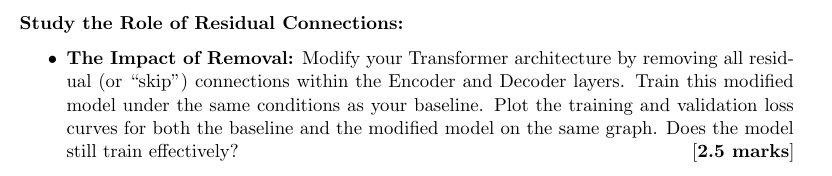

**OBSERVATION**

After removing all residual connections, the modified Transformer shows much poorer convergence compared to the baseline. In the baseline, validation loss steadily decreases with epochs, reaching values below 5.0, whereas in the no-residual models, the loss quickly plateaus around 6.2 and fails to improve further. This clearly shows that residual connections are crucial for smooth gradient flow and deeper learning.

Looking within the no-residual models, both multi-head and single-head attention reduce training loss initially, but their validation losses remain high and unstable. The multi-head variant performs slightly better, showing more stable validation loss compared to the fluctuating single-head model. However, neither comes close to baseline performance. Overall, these results highlight that residual connections are essential for stable training and effective learning in Transformers.

## IMPLEMENT **Learnable skip weights** AND TRAIN AGAIN TO OBSERVE THE CHANGES.

In [ ]:
# --- Experiment 2: IMPLEMENT LEARNABLE SKIP WEIGHTS ---


class EncoderLayerLearnableSkip(EncoderLayer):
    def __init__(self, d_model: int, n_heads: int, d_ff: int, dropout: float = 0.1):
        super().__init__(d_model, n_heads, d_ff, dropout)

        self.w_attn = nn.Parameter(torch.tensor(1.0))
        self.w_ffn = nn.Parameter(torch.tensor(1.0))

    def forward(self, x: torch.Tensor, mask: Optional[torch.Tensor] = None) -> torch.Tensor:

        attn_output = self.self_attn(x, x, x, mask)
        x = (self.w_attn * x) + self.dropout(attn_output)
        x = self.norm1(x)
        ffn_output = self.ffn(x)
        x = (self.w_ffn * x) + self.dropout(ffn_output)
        x = self.norm2(x)

        return x

class DecoderLayerLearnableSkip(DecoderLayer):
    def __init__(self, d_model: int, n_heads: int, d_ff: int, dropout: float = 0.1):
        super().__init__(d_model, n_heads, d_ff, dropout)
        self.w_self_attn = nn.Parameter(torch.tensor(1.0))
        self.w_cross_attn = nn.Parameter(torch.tensor(1.0))
        self.w_ffn = nn.Parameter(torch.tensor(1.0))

    def forward(self, x: torch.Tensor, encoder_output: torch.Tensor,
                src_mask: Optional[torch.Tensor] = None,
                tgt_mask: Optional[torch.Tensor] = None) -> torch.Tensor:
        attn_output = self.self_attn(x, x, x, tgt_mask)
        x = (self.w_self_attn * x) + self.dropout(attn_output)
        x = self.norm1(x)

        attn_output = self.cross_attn(x, encoder_output, encoder_output, src_mask)
        x = (self.w_cross_attn * x) + self.dropout(attn_output)
        x = self.norm2(x)

        ffn_output = self.ffn(x)
        x = (self.w_ffn * x) + self.dropout(ffn_output)
        x = self.norm3(x)

        return x

class EncoderLearnableSkip(Encoder):
    def __init__(self, n_layers: int, d_model: int, n_heads: int, d_ff: int, dropout: float = 0.1):
        super().__init__(n_layers, d_model, n_heads, d_ff, dropout)
        self.layers = nn.ModuleList([EncoderLayerLearnableSkip(d_model, n_heads, d_ff, dropout) for _ in range(n_layers)])

class DecoderLearnableSkip(Decoder):
    def __init__(self, n_layers: int, d_model: int, n_heads: int, d_ff: int, dropout: float = 0.1):
        super().__init__(n_layers, d_model, n_heads, d_ff, dropout)
        self.layers = nn.ModuleList([DecoderLayerLearnableSkip(d_model, n_heads, d_ff, dropout) for _ in range(n_layers)])

class TransformerLearnableSkip(TinyTransformer):
    def __init__(self, src_vocab_size: int, tgt_vocab_size: int,
                 d_model: int = 128, n_heads: int = 4, n_layers: int = 2,
                 d_ff: int = 512, max_seq_len: int = 128, dropout: float = 0.1):
        super().__init__(src_vocab_size, tgt_vocab_size, d_model, n_heads, n_layers, d_ff, max_seq_len, dropout)
        self.encoder = EncoderLearnableSkip(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = DecoderLearnableSkip(n_layers, d_model, n_heads, d_ff, dropout)

    def get_skip_weights(self):
        weights = {
            'encoder': [],
            'decoder': []
        }

        for layer in self.encoder.layers:
            layer_weights = {
                'w_attn': layer.w_attn.item(),
                'w_ffn': layer.w_ffn.item()
            }
            weights['encoder'].append(layer_weights)

        for layer in self.decoder.layers:
            layer_weights = {
                'w_self_attn': layer.w_self_attn.item(),
                'w_cross_attn': layer.w_cross_attn.item(),
                'w_ffn': layer.w_ffn.item()
            }
            weights['decoder'].append(layer_weights)
        return weights




In [ ]:
# ============================================
# TRAINING LOOP FOR LEARNABLE SKIP MODEL (Multi-head, 4 heads)
# ============================================

print("\n" + "="*50)
print("TRAINING LEARNABLE SKIP MODEL (4 heads)")
print("="*50)

model_learnable = TransformerLearnableSkip(
    src_vocab_size=len(de_vocab),
    tgt_vocab_size=len(en_vocab),
    **MODEL_CONFIGS['multi_head']
).to(device)

print(f"Learnable Skip model parameters: {count_parameters(model_learnable):,}")

optimizer_learnable = optim.Adam(model_learnable.parameters(), lr=LEARNING_RATE)
train_losses_learnable = []
val_losses_learnable = []
skip_weights_history = []

best_val_loss = float('inf')

for epoch in trange(N_EPOCHS, desc="Epochs"):
    start_time = time.time()
    train_loss = train_epoch(model_learnable, train_loader, optimizer_learnable, criterion)
    val_loss = evaluate(model_learnable, val_loader, criterion)
    skip_weights = model_learnable.get_skip_weights()
    skip_weights_history.append(skip_weights)

    end_time = time.time()
    epoch_mins, epoch_secs = divmod(end_time - start_time, 60)

    train_losses_learnable.append(train_loss)
    val_losses_learnable.append(val_loss)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model_learnable.state_dict(), 'tiny_transformer_learnable.pt')

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins:.0f}m {epoch_secs:.0f}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Val Loss: {val_loss:.3f}')


model_learnable.load_state_dict(torch.load('tiny_transformer_learnable.pt'))


TRAINING LEARNABLE SKIP MODEL (4 heads)
Learnable Skip model parameters: 4,776,218


Training: 100%|█████████▉| 545/547 [00:28<00:00, 18.60it/s]
                                                           
Epochs:  10%|█         | 1/10 [00:30<04:32, 30.28s/it]

Epoch: 01 | Time: 0m 30s
	Train Loss: 7.498 | Val Loss: 6.365



Training: 100%|██████████| 547/547 [00:27<00:00, 21.26it/s]
                                                           
Epochs:  20%|██        | 2/10 [00:59<03:57, 29.66s/it]

Epoch: 02 | Time: 0m 29s
	Train Loss: 6.114 | Val Loss: 5.850



Training: 100%|██████████| 547/547 [00:27<00:00, 22.40it/s]
                                                           
Epochs:  30%|███       | 3/10 [01:28<03:25, 29.39s/it]

Epoch: 03 | Time: 0m 29s
	Train Loss: 5.574 | Val Loss: 5.523



Training: 100%|█████████▉| 546/547 [00:28<00:00, 16.82it/s]
                                                           
Epochs:  40%|████      | 4/10 [01:58<02:56, 29.48s/it]

Epoch: 04 | Time: 0m 30s
	Train Loss: 5.221 | Val Loss: 5.328



Training: 100%|█████████▉| 545/547 [00:27<00:00, 21.31it/s]
                                                           
Epochs:  50%|█████     | 5/10 [02:27<02:27, 29.43s/it]

Epoch: 05 | Time: 0m 29s
	Train Loss: 5.006 | Val Loss: 5.186



Training: 100%|██████████| 547/547 [00:28<00:00, 22.27it/s]
                                                           
Epochs:  60%|██████    | 6/10 [02:56<01:57, 29.44s/it]

Epoch: 06 | Time: 0m 29s
	Train Loss: 4.850 | Val Loss: 5.055



Training: 100%|██████████| 547/547 [00:28<00:00, 18.62it/s]
                                                           
Epochs:  70%|███████   | 7/10 [03:27<01:29, 29.71s/it]

Epoch: 07 | Time: 0m 30s
	Train Loss: 4.724 | Val Loss: 4.972



Training: 100%|█████████▉| 545/547 [00:28<00:00, 19.08it/s]
                                                           
Epochs:  80%|████████  | 8/10 [03:56<00:59, 29.66s/it]

Epoch: 08 | Time: 0m 30s
	Train Loss: 4.616 | Val Loss: 4.900



Training: 100%|██████████| 547/547 [00:28<00:00, 20.26it/s]
                                                           
Epochs:  90%|█████████ | 9/10 [04:26<00:29, 29.61s/it]

Epoch: 09 | Time: 0m 29s
	Train Loss: 4.522 | Val Loss: 4.849



Training: 100%|█████████▉| 546/547 [00:28<00:00, 20.09it/s]
                                                           
Epochs: 100%|██████████| 10/10 [04:56<00:00, 29.68s/it]

Epoch: 10 | Time: 0m 30s
	Train Loss: 4.438 | Val Loss: 4.792


<All keys matched successfully>

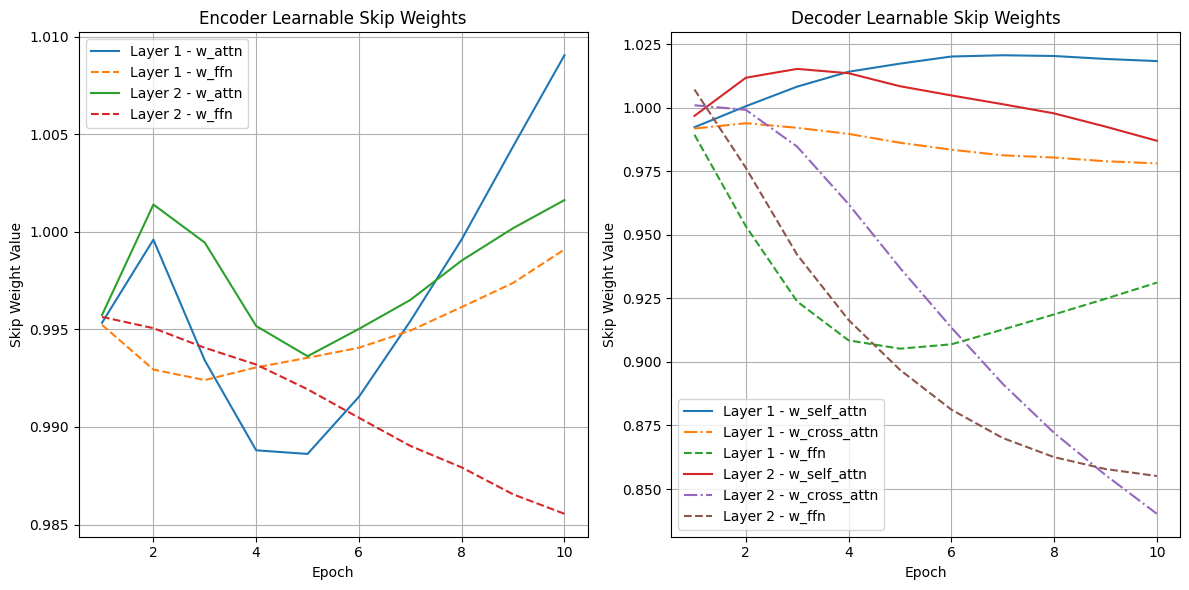

In [ ]:
# ============================================
# PLOT LEARNABLE SKIP WEIGHTS OVER EPOCHS
# ============================================

def plot_skip_weights(history):
    epochs = range(1, len(history) + 1)
    num_layers = len(history[0]['encoder'])

    plt.figure(figsize=(12, 6))


    plt.subplot(1, 2, 1)
    for layer_idx in range(num_layers):
        w_attn = [epoch_data['encoder'][layer_idx]['w_attn'] for epoch_data in history]
        w_ffn = [epoch_data['encoder'][layer_idx]['w_ffn'] for epoch_data in history]
        plt.plot(epochs, w_attn, label=f'Layer {layer_idx+1} - w_attn')
        plt.plot(epochs, w_ffn, label=f'Layer {layer_idx+1} - w_ffn', linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('Skip Weight Value')
    plt.title('Encoder Learnable Skip Weights')
    plt.legend()
    plt.grid(True)


    plt.subplot(1, 2, 2)
    for layer_idx in range(num_layers):
        w_self_attn = [epoch_data['decoder'][layer_idx]['w_self_attn'] for epoch_data in history]
        w_cross_attn = [epoch_data['decoder'][layer_idx]['w_cross_attn'] for epoch_data in history]
        w_ffn = [epoch_data['decoder'][layer_idx]['w_ffn'] for epoch_data in history]
        plt.plot(epochs, w_self_attn, label=f'Layer {layer_idx+1} - w_self_attn')
        plt.plot(epochs, w_cross_attn, label=f'Layer {layer_idx+1} - w_cross_attn', linestyle='-.')
        plt.plot(epochs, w_ffn, label=f'Layer {layer_idx+1} - w_ffn', linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('Skip Weight Value')
    plt.title('Decoder Learnable Skip Weights')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_skip_weights(skip_weights_history)

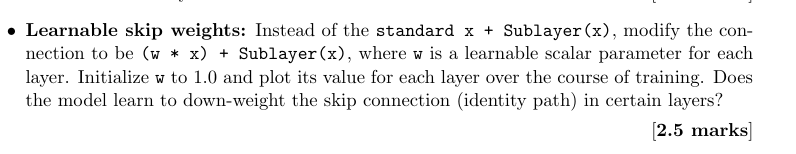

**OBSERVATION**

When introducing learnable skip weights, we initialized each 'w' at 1.0 and tracked them over training. The plots show that the model indeed adjusts these values across layers. In the encoder, some skip weights (e.g., Layer 2 feed-forward) gradually decrease below 0.99, indicating partial down-weighting of the identity path. In the decoder, stronger down-weighting is observed, especially in the second layer’s cross-attention and feed-forward skips, which fall close to 0.85. This suggests that the model learns to rely less on the raw input in deeper layers, allowing the sublayer transformations to dominate. Thus, the model does learn to selectively reduce the contribution of skip connections in certain layers during training.

## IMPLEMENT **Long-Range Skip Connections** AND TRAIN AGAIN TO OBSERVE THE CHANGES.

In [ ]:
import math
import torch
import torch.nn as nn

class EncoderWithLongSkips(nn.Module):
    def __init__(self, n_layers, d_model, n_heads, d_ff, dropout=0.1, skip_type="short"):
        super().__init__()
        self.n_layers = n_layers
        self.skip_type = skip_type
        self.layers = nn.ModuleList([EncoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(n_layers)])
        self.norm = nn.LayerNorm(d_model)
        if skip_type == "long":
            self.long_skip_proj = nn.Linear(d_model, d_model)

    def forward(self, x, mask=None):
        layer_outputs = []
        x0 = x

        for i, layer in enumerate(self.layers):
            if i == 0:
                x_in = x0
            else:
                if self.skip_type == "short":
                    if i == 1:
                        x_in = layer_outputs[i-1]
                    else:

                        x_in = (layer_outputs[i-1] + layer_outputs[i-2]) / math.sqrt(2.0)
                elif self.skip_type == "long" and i == self.n_layers - 1 and len(layer_outputs) > 0:

                    prev_out = layer_outputs[i-1]
                    first_out = layer_outputs[0]
                    projected_first = self.long_skip_proj(first_out) if hasattr(self, "long_skip_proj") else first_out
                    x_in = (prev_out + projected_first) / math.sqrt(2.0)
                else:

                    x_in = layer_outputs[i-1]

            x = layer(x_in, mask)
            layer_outputs.append(x)

        return self.norm(x)


class DecoderWithLongSkips(nn.Module):
    def __init__(self, n_layers, d_model, n_heads, d_ff, dropout=0.1, skip_type="short"):
        super().__init__()
        self.n_layers = n_layers
        self.skip_type = skip_type
        self.layers = nn.ModuleList([DecoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(n_layers)])
        self.norm = nn.LayerNorm(d_model)
        if skip_type == "long":
            self.long_skip_proj = nn.Linear(d_model, d_model)

    def forward(self, x, encoder_output, src_mask=None, tgt_mask=None):
        layer_outputs = []
        x0 = x

        for i, layer in enumerate(self.layers):
            if i == 0:
                x_in = x0
            else:
                if self.skip_type == "short":
                    if i == 1:
                        x_in = layer_outputs[i-1]
                    else:
                        x_in = (layer_outputs[i-1] + layer_outputs[i-2]) / math.sqrt(2.0)
                elif self.skip_type == "long" and i == self.n_layers - 1 and len(layer_outputs) > 0:
                    prev_out = layer_outputs[i-1]
                    first_out = layer_outputs[0]
                    projected_first = self.long_skip_proj(first_out) if hasattr(self, "long_skip_proj") else first_out
                    x_in = (prev_out + projected_first) / math.sqrt(2.0)
                else:
                    x_in = layer_outputs[i-1]

            x = layer(x_in, encoder_output, src_mask, tgt_mask)
            layer_outputs.append(x)

        return self.norm(x)

In [ ]:
class TransformerLongSkip(nn.Module):
    def __init__(self, src_vocab_size: int, tgt_vocab_size: int,
                 d_model: int = 128, n_heads: int = 4, n_layers: int = 2,
                 d_ff: int = 512, max_seq_len: int = 128,
                 dropout: float = 0.1, skip_type: str = "short"):
        super().__init__()

        self.d_model = d_model
        self.n_heads = n_heads
        self.skip_type = skip_type
        self.src_embed = nn.Embedding(src_vocab_size, d_model)
        self.tgt_embed = nn.Embedding(tgt_vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_seq_len)
        self.encoder = EncoderWithLongSkips(
            n_layers=n_layers, d_model=d_model, n_heads=n_heads,
            d_ff=d_ff, dropout=dropout, skip_type=skip_type
        )
        self.decoder = DecoderWithLongSkips(
            n_layers=n_layers, d_model=d_model, n_heads=n_heads,
            d_ff=d_ff, dropout=dropout, skip_type=skip_type
        )
        self.output_proj = nn.Linear(d_model, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)
        self._init_parameters()

    def _init_parameters(self):

        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def create_src_mask(self, src: torch.Tensor) -> torch.Tensor:
        return (src != PAD_IDX).unsqueeze(1).unsqueeze(2)

    def create_tgt_mask(self, tgt: torch.Tensor) -> torch.Tensor:
        batch_size, tgt_len = tgt.shape
        pad_mask = (tgt != PAD_IDX).unsqueeze(1).unsqueeze(2)
        causal_mask = torch.tril(
            torch.ones(tgt_len, tgt_len, dtype=torch.bool, device=tgt.device)
        ).unsqueeze(0).unsqueeze(1)
        return pad_mask & causal_mask

    def encode(self, src: torch.Tensor, src_mask: torch.Tensor) -> torch.Tensor:
        x = self.src_embed(src) * math.sqrt(self.d_model)
        x = self.pos_encoding(x)
        x = self.dropout(x)
        return self.encoder(x, src_mask)

    def decode(self, tgt: torch.Tensor, encoder_output: torch.Tensor,
               src_mask: torch.Tensor, tgt_mask: torch.Tensor) -> torch.Tensor:
        x = self.tgt_embed(tgt) * math.sqrt(self.d_model)
        x = self.pos_encoding(x)
        x = self.dropout(x)
        return self.decoder(x, encoder_output, src_mask, tgt_mask)

    def forward(self, src: torch.Tensor, tgt: torch.Tensor) -> torch.Tensor:
        src_mask = self.create_src_mask(src)
        tgt_mask = self.create_tgt_mask(tgt)
        memory = self.encode(src, src_mask)
        dec_out = self.decode(tgt, memory, src_mask, tgt_mask)
        return self.output_proj(dec_out)

    def get_attention_weights(self):

        attention_weights = {
            'encoder_self_attention': [],
            'decoder_self_attention': [],
            'decoder_cross_attention': []
        }
        for layer in self.encoder.layers:
            attn = getattr(layer.self_attn, 'attention_weights', None)
            attention_weights['encoder_self_attention'].append(
                attn.detach().cpu() if attn is not None else None
            )
        for layer in self.decoder.layers:
            self_attn = getattr(layer.self_attn, 'attention_weights', None)
            cross_attn = getattr(layer.cross_attn, 'attention_weights', None)
            attention_weights['decoder_self_attention'].append(
                self_attn.detach().cpu() if self_attn is not None else None
            )
            attention_weights['decoder_cross_attention'].append(
                cross_attn.detach().cpu() if cross_attn is not None else None
            )
        return attention_weights



In [ ]:
print("\n" + "="*60)
print("TRAINING LONG-RANGE SKIP CONNECTION MODELS")
print("="*60)
try:
    model_short_skip = TransformerLongSkip(
        src_vocab_size=len(de_vocab),
        tgt_vocab_size=len(en_vocab),
        skip_type="short",
        **MODEL_CONFIGS['multi_head']
    ).to(device)

    model_long_skip = TransformerLongSkip(
        src_vocab_size=len(de_vocab),
        tgt_vocab_size=len(en_vocab),
        skip_type="long",
        **MODEL_CONFIGS['multi_head']
    ).to(device)

    print(f"Short-skip model parameters: {count_parameters(model_short_skip):,}")
    print(f"Long-skip model parameters: {count_parameters(model_long_skip):,}")

except Exception as e:
    print(f"Error initializing models: {e}")
    raise




TRAINING LONG-RANGE SKIP CONNECTION MODELS
Short-skip model parameters: 4,776,208
Long-skip model parameters: 4,809,232


In [ ]:
def train_skip_model_safe(model, model_name, save_name):
    print(f"\n{'='*50}")
    print(f"TRAINING {model_name}")
    print(f"{'='*50}")

    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')

    try:
        for epoch in trange(N_EPOCHS, desc=f"{model_name} Epochs"):
            start_time = time.time()
            try:
                train_loss = train_epoch(model, train_loader, optimizer, criterion)
            except Exception as e:
                print(f"Error during training epoch {epoch+1}: {e}")
                print(f"Model type: {type(model)}")
                print(f"Skip type: {getattr(model, 'skip_type', 'unknown')}")
                raise

            try:
                val_loss = evaluate(model, val_loader, criterion)
            except Exception as e:
                print(f"Error during validation epoch {epoch+1}: {e}")
                raise

            end_time = time.time()
            epoch_mins, epoch_secs = divmod(end_time - start_time, 60)

            train_losses.append(train_loss)
            val_losses.append(val_loss)


            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(model.state_dict(), f'{save_name}.pt')

            print(f'Epoch: {epoch+1:02} | Time: {epoch_mins:.0f}m {epoch_secs:.0f}s')
            print(f'\tTrain Loss: {train_loss:.3f} | Val Loss: {val_loss:.3f}')


        model.load_state_dict(torch.load(f'{save_name}.pt'))
        return train_losses, val_losses

    except Exception as e:
        print(f"Training failed for {model_name}: {e}")
        return [], []

print("Starting short-range skip model training...")
train_losses_short, val_losses_short = train_skip_model_safe(
    model_short_skip, "SHORT-RANGE SKIP MODEL", "tiny_transformer_short_skip"
)

print("Starting long-range skip model training...")
train_losses_long, val_losses_long = train_skip_model_safe(
    model_long_skip, "LONG-RANGE SKIP MODEL", "tiny_transformer_long_skip"
)


Starting short-range skip model training...

TRAINING SHORT-RANGE SKIP MODEL


Training: 100%|██████████| 547/547 [00:27<00:00, 18.13it/s]
                                                           
SHORT-RANGE SKIP MODEL Epochs:  10%|█         | 1/10 [00:29<04:22, 29.15s/it]

Epoch: 01 | Time: 0m 29s
	Train Loss: 7.475 | Val Loss: 6.345



Training: 100%|██████████| 547/547 [00:27<00:00, 21.62it/s]
                                                           
SHORT-RANGE SKIP MODEL Epochs:  20%|██        | 2/10 [00:57<03:50, 28.84s/it]

Epoch: 02 | Time: 0m 29s
	Train Loss: 6.137 | Val Loss: 5.864



Training: 100%|█████████▉| 546/547 [00:26<00:00, 21.29it/s]
                                                           
SHORT-RANGE SKIP MODEL Epochs:  30%|███       | 3/10 [01:26<03:20, 28.60s/it]

Epoch: 03 | Time: 0m 28s
	Train Loss: 5.624 | Val Loss: 5.550



Training: 100%|█████████▉| 545/547 [00:27<00:00, 20.76it/s]
                                                           
SHORT-RANGE SKIP MODEL Epochs:  40%|████      | 4/10 [01:54<02:51, 28.58s/it]

Epoch: 04 | Time: 0m 28s
	Train Loss: 5.279 | Val Loss: 5.380



Training: 100%|█████████▉| 546/547 [00:27<00:00, 16.56it/s]
                                                           
SHORT-RANGE SKIP MODEL Epochs:  50%|█████     | 5/10 [02:23<02:24, 28.83s/it]

Epoch: 05 | Time: 0m 29s
	Train Loss: 5.073 | Val Loss: 5.251



Training: 100%|█████████▉| 546/547 [00:27<00:00, 22.12it/s]
                                                           
SHORT-RANGE SKIP MODEL Epochs:  60%|██████    | 6/10 [02:52<01:54, 28.72s/it]

Epoch: 06 | Time: 0m 28s
	Train Loss: 4.930 | Val Loss: 5.149



Training: 100%|█████████▉| 546/547 [00:27<00:00, 22.06it/s]
                                                           
SHORT-RANGE SKIP MODEL Epochs:  70%|███████   | 7/10 [03:21<01:26, 28.76s/it]

Epoch: 07 | Time: 0m 29s
	Train Loss: 4.815 | Val Loss: 5.056



Training: 100%|█████████▉| 546/547 [00:27<00:00, 21.88it/s]
                                                           
SHORT-RANGE SKIP MODEL Epochs:  80%|████████  | 8/10 [03:49<00:57, 28.75s/it]

Epoch: 08 | Time: 0m 29s
	Train Loss: 4.714 | Val Loss: 4.977



Training: 100%|█████████▉| 546/547 [00:28<00:00, 17.79it/s]
                                                           
SHORT-RANGE SKIP MODEL Epochs:  90%|█████████ | 9/10 [04:19<00:29, 29.05s/it]

Epoch: 09 | Time: 0m 30s
	Train Loss: 4.627 | Val Loss: 4.934



Training: 100%|█████████▉| 545/547 [00:27<00:00, 20.42it/s]
                                                           
SHORT-RANGE SKIP MODEL Epochs: 100%|██████████| 10/10 [04:48<00:00, 28.86s/it]


Epoch: 10 | Time: 0m 29s
	Train Loss: 4.549 | Val Loss: 4.866
Starting long-range skip model training...

TRAINING LONG-RANGE SKIP MODEL


Training: 100%|█████████▉| 545/547 [00:27<00:00, 20.59it/s]
                                                           
LONG-RANGE SKIP MODEL Epochs:  10%|█         | 1/10 [00:29<04:24, 29.40s/it]

Epoch: 01 | Time: 0m 29s
	Train Loss: 7.517 | Val Loss: 6.355



Training: 100%|██████████| 547/547 [00:28<00:00, 21.54it/s]
                                                           
LONG-RANGE SKIP MODEL Epochs:  20%|██        | 2/10 [00:59<03:57, 29.68s/it]

Epoch: 02 | Time: 0m 30s
	Train Loss: 6.117 | Val Loss: 5.857



Training: 100%|█████████▉| 545/547 [00:28<00:00, 19.90it/s]
                                                           
LONG-RANGE SKIP MODEL Epochs:  30%|███       | 3/10 [01:29<03:28, 29.83s/it]

Epoch: 03 | Time: 0m 30s
	Train Loss: 5.611 | Val Loss: 5.561



Training: 100%|██████████| 547/547 [00:28<00:00, 20.62it/s]
                                                           
LONG-RANGE SKIP MODEL Epochs:  40%|████      | 4/10 [01:58<02:58, 29.71s/it]

Epoch: 04 | Time: 0m 29s
	Train Loss: 5.272 | Val Loss: 5.399



Training: 100%|█████████▉| 545/547 [00:28<00:00, 19.61it/s]
                                                           
LONG-RANGE SKIP MODEL Epochs:  50%|█████     | 5/10 [02:28<02:28, 29.70s/it]

Epoch: 05 | Time: 0m 30s
	Train Loss: 5.067 | Val Loss: 5.275



Training: 100%|█████████▉| 546/547 [00:28<00:00, 18.03it/s]
                                                           
LONG-RANGE SKIP MODEL Epochs:  60%|██████    | 6/10 [02:58<01:59, 29.85s/it]

Epoch: 06 | Time: 0m 30s
	Train Loss: 4.922 | Val Loss: 5.154



Training: 100%|█████████▉| 545/547 [00:28<00:00, 20.59it/s]
                                                           
LONG-RANGE SKIP MODEL Epochs:  70%|███████   | 7/10 [03:28<01:29, 29.74s/it]

Epoch: 07 | Time: 0m 29s
	Train Loss: 4.806 | Val Loss: 5.053



Training: 100%|█████████▉| 546/547 [00:28<00:00, 20.12it/s]
                                                           
LONG-RANGE SKIP MODEL Epochs:  80%|████████  | 8/10 [03:57<00:59, 29.68s/it]

Epoch: 08 | Time: 0m 30s
	Train Loss: 4.704 | Val Loss: 4.978



Training: 100%|█████████▉| 546/547 [00:28<00:00, 20.26it/s]
                                                           
LONG-RANGE SKIP MODEL Epochs:  90%|█████████ | 9/10 [04:27<00:29, 29.79s/it]

Epoch: 09 | Time: 0m 30s
	Train Loss: 4.616 | Val Loss: 4.911



Training: 100%|█████████▉| 545/547 [00:28<00:00, 17.78it/s]
                                                           
LONG-RANGE SKIP MODEL Epochs: 100%|██████████| 10/10 [04:57<00:00, 29.75s/it]

Epoch: 10 | Time: 0m 30s
	Train Loss: 4.538 | Val Loss: 4.867


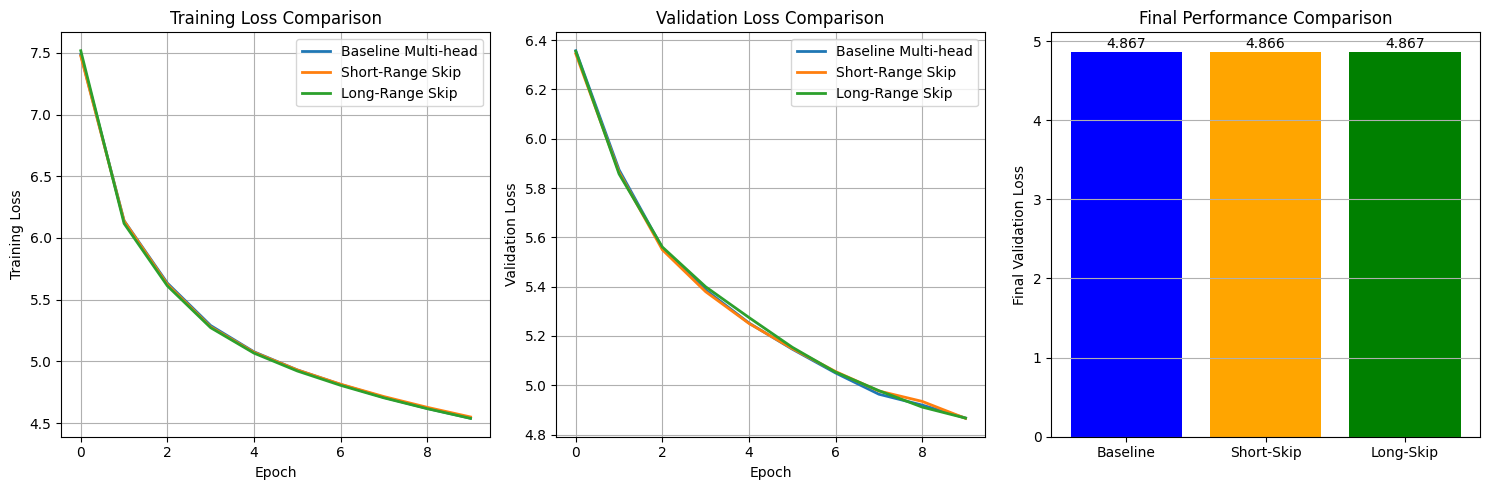

 Training completed successfully for both models!


In [ ]:
if train_losses_short and train_losses_long:
    plt.figure(figsize=(15, 5))

    # Training losses
    plt.subplot(1, 3, 1)
    plt.plot(train_losses_multi, label='Baseline Multi-head', linewidth=2)
    plt.plot(train_losses_short, label='Short-Range Skip', linewidth=2)
    plt.plot(train_losses_long, label='Long-Range Skip', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Training Loss')
    plt.title('Training Loss Comparison')
    plt.legend()
    plt.grid(True)

    # Validation losses
    plt.subplot(1, 3, 2)
    plt.plot(val_losses_multi, label='Baseline Multi-head', linewidth=2)
    plt.plot(val_losses_short, label='Short-Range Skip', linewidth=2)
    plt.plot(val_losses_long, label='Long-Range Skip', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Validation Loss')
    plt.title('Validation Loss Comparison')
    plt.legend()
    plt.grid(True)


    plt.subplot(1, 3, 3)
    final_losses = [val_losses_multi[-1], val_losses_short[-1], val_losses_long[-1]]
    model_names = ['Baseline', 'Short-Skip', 'Long-Skip']
    bars = plt.bar(model_names, final_losses, color=['blue', 'orange', 'green'])
    plt.ylabel('Final Validation Loss')
    plt.title('Final Performance Comparison')
    plt.grid(True, axis='y')


    for bar, loss in zip(bars, final_losses):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                 f'{loss:.3f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    print(" Training completed successfully for both models!")

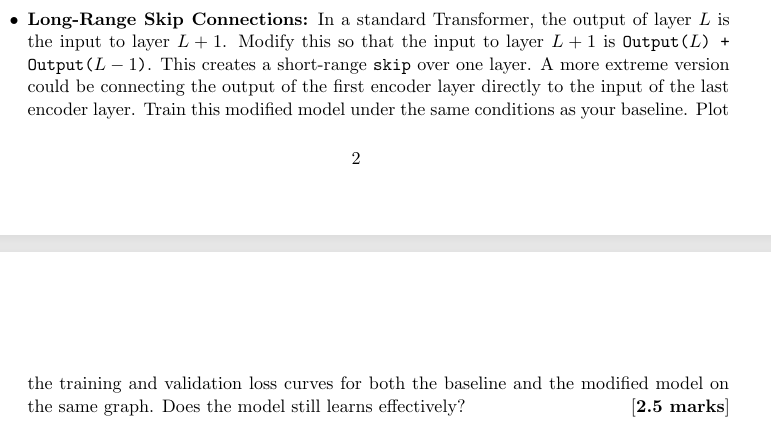

Yes, the model still learns effectively with both short-range and long-range skip modifications. From the training and validation loss plots, we see that all three models (baseline, short-skip, and long-skip) converge smoothly with almost identical loss trajectories. The final validation losses are also nearly the same (≈4.867), showing no degradation in performance. This means that adding extra skip paths does not harm learning stability or convergence.

## PART 2(B)

**Study the Role of Feed-Forward Layers**

- Answer the questions as asked in the Assignemnt.

## Solution 2(B)

In [ ]:
# --- Experiment 1: Removing Feed-Forward Layers ---

class EncoderLayerNoFFN(nn.Module):

    def __init__(self, d_model: int, n_heads: int, d_ff: int, dropout: float = 0.1):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, n_heads, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor, mask: Optional[torch.Tensor] = None) -> torch.Tensor:
        attn_out = self.self_attn(x, x, x, mask)
        x = x + self.dropout(attn_out)
        x = self.norm1(x)
        return x


class DecoderLayerNoFFN(nn.Module):

    def __init__(self, d_model: int, n_heads: int, d_ff: int, dropout: float = 0.1):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, n_heads, dropout)
        self.enc_attn = MultiHeadAttention(d_model, n_heads, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(
        self,
        x: torch.Tensor,
        encoder_output: torch.Tensor,
        src_mask: Optional[torch.Tensor] = None,
        tgt_mask: Optional[torch.Tensor] = None
    ) -> torch.Tensor:
        self_attn_out = self.self_attn(x, x, x, tgt_mask)
        x = x + self.dropout(self_attn_out)
        x = self.norm1(x)

        enc_attn_out = self.enc_attn(x, encoder_output, encoder_output, src_mask)
        x = x + self.dropout(enc_attn_out)
        x = self.norm2(x)

        return x


class EncoderNoFFN(nn.Module):
    def __init__(self, n_layers: int, d_model: int, n_heads: int, d_ff: int, dropout: float = 0.1):
        super().__init__()
        self.layers = nn.ModuleList(
            [EncoderLayerNoFFN(d_model, n_heads, d_ff, dropout) for _ in range(n_layers)]
        )
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x: torch.Tensor, mask: Optional[torch.Tensor] = None) -> torch.Tensor:
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)


class DecoderNoFFN(nn.Module):
    def __init__(self, n_layers: int, d_model: int, n_heads: int, d_ff: int, dropout: float = 0.1):
        super().__init__()
        self.layers = nn.ModuleList(
            [DecoderLayerNoFFN(d_model, n_heads, d_ff, dropout) for _ in range(n_layers)]
        )
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x: torch.Tensor, encoder_output: torch.Tensor,
                src_mask: Optional[torch.Tensor] = None, tgt_mask: Optional[torch.Tensor] = None) -> torch.Tensor:
        for layer in self.layers:
            x = layer(x, encoder_output, src_mask, tgt_mask)
        return self.norm(x)


class TransformerNoFFN(TinyTransformer):

    def __init__(self, src_vocab_size: int, tgt_vocab_size: int,
                 d_model: int = 128, n_heads: int = 4, n_layers: int = 2,
                 d_ff: int = 512, max_seq_len: int = 128, dropout: float = 0.1):
        super().__init__(src_vocab_size, tgt_vocab_size,
                         d_model, n_heads, n_layers, d_ff, max_seq_len, dropout)


        self.encoder = EncoderNoFFN(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = DecoderNoFFN(n_layers, d_model, n_heads, d_ff, dropout)


In [ ]:
baseline = TinyTransformer(len(de_vocab), len(en_vocab), **MODEL_CONFIGS['multi_head']).to(device)
noffn    = TransformerNoFFN(len(de_vocab), len(en_vocab), **MODEL_CONFIGS['multi_head']).to(device)

params_baseline = count_parameters(baseline)
params_noffn    = count_parameters(noffn)
reduction_pct = 100 * (params_baseline - params_noffn) / params_baseline

print(f"Baseline params: {params_baseline:,}")
print(f"No-FFN params:  {params_noffn:,}")
print(f"Reduction: {reduction_pct:.2f}%")


Baseline params: 4,776,208
No-FFN params:  4,248,336
Reduction: 11.05%


In [ ]:
optimizer_noffn = optim.Adam(noffn.parameters(), lr=LEARNING_RATE)
train_losses_noffn, val_losses_noffn = [], []

for epoch in trange(N_EPOCHS, desc="No-FFN Training"):
    train_loss = train_epoch(noffn, train_loader, optimizer_noffn, criterion)
    val_loss   = evaluate(noffn, val_loader, criterion)
    train_losses_noffn.append(train_loss)
    val_losses_noffn.append(val_loss)
    print(f"Epoch {epoch+1}: train={train_loss:.3f} val={val_loss:.3f}")

Training:  99%|█████████▉| 544/547 [00:22<00:00, 20.14it/s]
                                                           
No-FFN Training:  10%|█         | 1/10 [00:23<03:33, 23.71s/it]

Epoch 1: train=7.526 val=6.388



Training: 100%|█████████▉| 545/547 [00:22<00:00, 25.33it/s]
                                                           
No-FFN Training:  20%|██        | 2/10 [00:47<03:10, 23.82s/it]

Epoch 2: train=6.227 val=5.972



Training: 100%|█████████▉| 546/547 [00:22<00:00, 26.28it/s]
                                                           
No-FFN Training:  30%|███       | 3/10 [01:11<02:45, 23.69s/it]

Epoch 3: train=5.741 val=5.618



Training: 100%|██████████| 547/547 [00:22<00:00, 27.97it/s]
                                                           
No-FFN Training:  40%|████      | 4/10 [01:35<02:22, 23.82s/it]

Epoch 4: train=5.352 val=5.404



Training: 100%|█████████▉| 545/547 [00:22<00:00, 25.34it/s]
                                                           
No-FFN Training:  50%|█████     | 5/10 [01:59<01:59, 23.93s/it]

Epoch 5: train=5.104 val=5.254



Training: 100%|█████████▉| 545/547 [00:22<00:00, 25.44it/s]
                                                           
No-FFN Training:  60%|██████    | 6/10 [02:23<01:35, 23.96s/it]

Epoch 6: train=4.935 val=5.131



Training: 100%|█████████▉| 545/547 [00:23<00:00, 25.67it/s]
                                                           
No-FFN Training:  70%|███████   | 7/10 [02:47<01:12, 24.07s/it]

Epoch 7: train=4.802 val=5.042



Training:  99%|█████████▉| 544/547 [00:23<00:00, 25.82it/s]
                                                           
No-FFN Training:  80%|████████  | 8/10 [03:11<00:48, 24.16s/it]

Epoch 8: train=4.689 val=4.958



Training: 100%|█████████▉| 546/547 [00:23<00:00, 22.93it/s]
                                                           
No-FFN Training:  90%|█████████ | 9/10 [03:36<00:24, 24.18s/it]

Epoch 9: train=4.589 val=4.887



Training: 100%|█████████▉| 545/547 [00:22<00:00, 19.97it/s]
                                                           
No-FFN Training: 100%|██████████| 10/10 [04:00<00:00, 24.06s/it]

Epoch 10: train=4.496 val=4.837


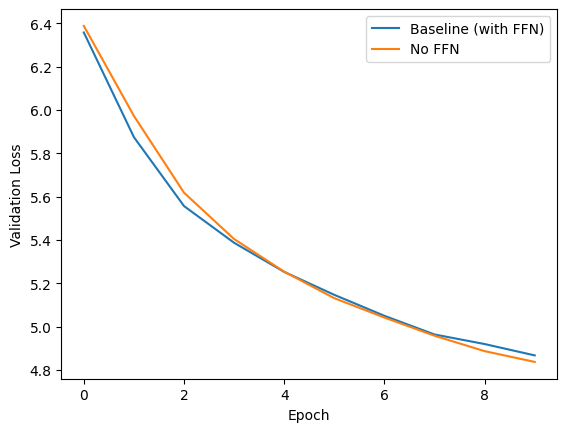

In [ ]:
# plot vs baseline
plt.plot(val_losses_multi, label="Baseline (with FFN)")
plt.plot(val_losses_noffn, label="No FFN")
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.legend()
plt.show()

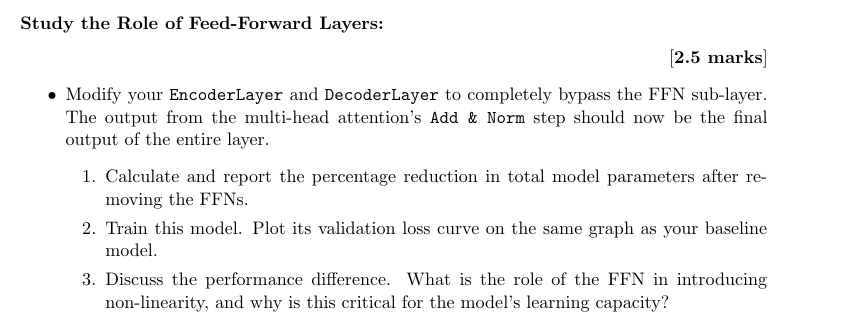

Baseline params: 4,776,208
No-FFN params:  4,248,336
Reduction: 11.05%

Removing the FFN layers reduced the total parameters by around 11- 12 %, making the model lighter. The baseline (with FFN) performs slightly better, but the no-FFN model is not far behind. This shows that FFNs are not strictly necessary for the model to train, but they are important for improving representation power. The role of the FFN is to introduce non-linearity, which allows the Transformer to learn more complex functions. Without FFNs, the model is mostly linear and has reduced learning capacity.In larger real-world tasks, FFNs are critical for achieving strong performance.

# PART:3 (Attention Modulation)

 - Implement Token Distance as an Attention Bias (as asked in assignemnt)

## Soultion 3(A)

$$
\text{Standard attention: }
\mathrm{Attn}(Q,K,V) = \mathrm{softmax}\!\left(\frac{QK^\top}{\sqrt{d_k}}\right)V
$$

$$
\text{Introduce distance bias: }
B_{ij} = |i-j|^2
$$

$$
\text{With learnable scalar } \alpha \in \mathbb{R},
\quad S = \frac{QK^\top}{\sqrt{d_k}} + \alpha B
$$

$$
A = \mathrm{softmax}(S),
\quad \mathrm{Attn}_{\text{ distance - aware}}(Q,K,V) = AV
$$


In [ ]:
# ==============================================================================
# TOOD: ATTENTION MODULATION (Token Distance Bias)
# ==============================================================================

class DistanceAwareMultiHeadAttention(MultiHeadAttention):
    def __init__(self, d_model: int, n_heads: int, dropout: float = 0.1, max_seq_len: int = 128):
        super().__init__(d_model, n_heads, dropout)
        # Create a distance bias matrix that is not a model parameter
        # TOOD
        distance_matrix = torch.arange(max_seq_len).unsqueeze(0) - torch.arange(max_seq_len).unsqueeze(1)
        distance_matrix = distance_matrix.abs().float()
        distance_matrix = distance_matrix ** 2
        self.register_buffer("distance_bias", distance_matrix)
        self.alpha = nn.Parameter(torch.tensor(-0.001))



    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        d_k = Q.size(-1)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(d_k)

        seq_len = scores.size(-1)
        distance_penalty = self.alpha * self.distance_bias[:seq_len, :seq_len]
        scores = scores + distance_penalty

        if mask is not None:
            mask = mask.to(dtype=torch.bool, device=scores.device)
            if mask.dim() == 2:
                mask = mask.unsqueeze(1).unsqueeze(2)
                mask = mask.expand(-1, 1, scores.size(2), -1)
            elif mask.dim() == 3:
                mask = mask.unsqueeze(1)
            scores = scores.masked_fill(~mask, float("-inf"))

        attn_weights = F.softmax(scores, dim=-1)
        attn_weights = self.dropout(attn_weights)
        output = torch.matmul(attn_weights, V)

        return output, attn_weights


class EncoderLayerDistanceAware(EncoderLayer):
    def __init__(self, d_model: int, n_heads: int, d_ff: int, dropout: float = 0.1, max_seq_len: int = 128):
        super().__init__(d_model, n_heads, d_ff, dropout)
        # TOOD
        self.self_attn = DistanceAwareMultiHeadAttention(d_model, n_heads, dropout, max_seq_len)


class EncoderDistanceAware(Encoder):
    def __init__(self, n_layers: int, d_model: int, n_heads: int, d_ff: int, dropout: float = 0.1, max_seq_len: int = 128):
        super().__init__(n_layers, d_model, n_heads, d_ff, dropout)
        # TOOD
        self.layers = nn.ModuleList([
            EncoderLayerDistanceAware(d_model, n_heads, d_ff, dropout, max_seq_len)
            for _ in range(n_layers)
        ])


class TransformerDistanceAware(TinyTransformer):
    def __init__(self, *args, max_seq_len=128, **kwargs):
        super().__init__(*args, **kwargs)

        # Only modify the encoder for this experiment for simplicity (You may choose)
        # TOOD
        self.encoder = EncoderDistanceAware(
            n_layers=len(self.encoder.layers),
            d_model=self.encoder.layers[0].self_attn.d_model,
            n_heads=self.encoder.layers[0].self_attn.n_heads,
            d_ff=self.encoder.layers[0].ffn.fc1.out_features,
            dropout=self.encoder.layers[0].dropout.p,
            max_seq_len=max_seq_len
        )


## Solution 3(B)

In [ ]:
# =====================================================
# Part-3: Implementation and Evaluation
# Distance-Aware Attention vs Baseline
# =====================================================

# --- Baseline Transformer ---
baseline_model = TinyTransformer(
    src_vocab_size=len(de_vocab),
    tgt_vocab_size=len(en_vocab),
    **MODEL_CONFIGS['multi_head']
).to(device)

optimizer_base = optim.Adam(baseline_model.parameters(), lr=LEARNING_RATE)
baseline_train_losses, baseline_val_losses = [], []
best_val_loss = float('inf')

print("\nTraining Baseline (Multi-head)...")
for epoch in trange(N_EPOCHS, desc="Baseline Training"):
    train_loss = train_epoch(baseline_model, train_loader, optimizer_base, criterion)
    val_loss = evaluate(baseline_model, val_loader, criterion)

    baseline_train_losses.append(train_loss)
    baseline_val_losses.append(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(baseline_model.state_dict(), "baseline_model.pt")

    print(f"Epoch {epoch+1}: Train Loss={train_loss:.3f}, Val Loss={val_loss:.3f}")

baseline_model.load_state_dict(torch.load("baseline_model.pt"))


Training Baseline (Multi-head)...


Training: 100%|██████████| 547/547 [00:26<00:00, 22.21it/s]
                                                           
Baseline Training:  10%|█         | 1/10 [00:27<04:08, 27.65s/it]

Epoch 1: Train Loss=7.492, Val Loss=6.369



Training: 100%|█████████▉| 546/547 [00:26<00:00, 20.27it/s]
                                                           
Baseline Training:  20%|██        | 2/10 [00:55<03:41, 27.75s/it]

Epoch 2: Train Loss=6.131, Val Loss=5.854



Training: 100%|██████████| 547/547 [00:26<00:00, 22.80it/s]
                                                           
Baseline Training:  30%|███       | 3/10 [01:23<03:14, 27.79s/it]

Epoch 3: Train Loss=5.611, Val Loss=5.534



Training: 100%|█████████▉| 545/547 [00:26<00:00, 21.58it/s]
                                                           
Baseline Training:  40%|████      | 4/10 [01:51<02:47, 27.86s/it]

Epoch 4: Train Loss=5.272, Val Loss=5.360



Training: 100%|█████████▉| 546/547 [00:27<00:00, 18.54it/s]
                                                           
Baseline Training:  50%|█████     | 5/10 [02:19<02:20, 28.15s/it]

Epoch 5: Train Loss=5.071, Val Loss=5.247



Training: 100%|██████████| 547/547 [00:26<00:00, 21.69it/s]
                                                           
Baseline Training:  60%|██████    | 6/10 [02:48<01:52, 28.18s/it]

Epoch 6: Train Loss=4.929, Val Loss=5.129



Training: 100%|█████████▉| 545/547 [00:26<00:00, 19.63it/s]
                                                           
Baseline Training:  70%|███████   | 7/10 [03:16<01:24, 28.19s/it]

Epoch 7: Train Loss=4.814, Val Loss=5.047



Training: 100%|█████████▉| 545/547 [00:26<00:00, 20.79it/s]
                                                           
Baseline Training:  80%|████████  | 8/10 [03:44<00:56, 28.23s/it]

Epoch 8: Train Loss=4.712, Val Loss=4.958



Training: 100%|█████████▉| 545/547 [00:26<00:00, 21.42it/s]
                                                           
Baseline Training:  90%|█████████ | 9/10 [04:13<00:28, 28.40s/it]

Epoch 9: Train Loss=4.622, Val Loss=4.911



Training: 100%|██████████| 547/547 [00:27<00:00, 21.45it/s]
                                                           
Baseline Training: 100%|██████████| 10/10 [04:42<00:00, 28.23s/it]


Epoch 10: Train Loss=4.542, Val Loss=4.853


<All keys matched successfully>

In [ ]:
# --- Distance-Aware Transformer ---
distance_model = TransformerDistanceAware(
    src_vocab_size=len(de_vocab),
    tgt_vocab_size=len(en_vocab),
    **MODEL_CONFIGS['multi_head'],
    max_seq_len=128
).to(device)

optimizer_dist = optim.Adam(distance_model.parameters(), lr=LEARNING_RATE)
distance_train_losses, distance_val_losses = [], []
best_val_loss = float('inf')

print("\nTraining Distance-Aware Transformer...")
for epoch in trange(N_EPOCHS, desc="Distance-Aware Training"):
    train_loss = train_epoch(distance_model, train_loader, optimizer_dist, criterion)
    val_loss = evaluate(distance_model, val_loader, criterion)

    distance_train_losses.append(train_loss)
    distance_val_losses.append(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(distance_model.state_dict(), "distance_model.pt")

    print(f"Epoch {epoch+1}: Train Loss={train_loss:.3f}, Val Loss={val_loss:.3f}")

distance_model.load_state_dict(torch.load("distance_model.pt"))



Training Distance-Aware Transformer...


Training: 100%|██████████| 547/547 [00:26<00:00, 22.68it/s]
                                                           
Distance-Aware Training:  10%|█         | 1/10 [00:27<04:11, 27.96s/it]

Epoch 1: Train Loss=7.508, Val Loss=6.378



Training: 100%|█████████▉| 546/547 [00:26<00:00, 21.59it/s]
                                                           
Distance-Aware Training:  20%|██        | 2/10 [00:56<03:44, 28.06s/it]

Epoch 2: Train Loss=6.136, Val Loss=5.862



Training: 100%|█████████▉| 545/547 [00:26<00:00, 20.92it/s]
                                                           
Distance-Aware Training:  30%|███       | 3/10 [01:24<03:19, 28.44s/it]

Epoch 3: Train Loss=5.633, Val Loss=5.547



Training: 100%|█████████▉| 545/547 [00:27<00:00, 21.12it/s]
                                                           
Distance-Aware Training:  40%|████      | 4/10 [01:53<02:50, 28.46s/it]

Epoch 4: Train Loss=5.282, Val Loss=5.380



Training: 100%|█████████▉| 546/547 [00:27<00:00, 20.54it/s]
                                                           
Distance-Aware Training:  50%|█████     | 5/10 [02:21<02:22, 28.41s/it]

Epoch 5: Train Loss=5.066, Val Loss=5.256



Training: 100%|█████████▉| 546/547 [00:27<00:00, 20.51it/s]
                                                           
Distance-Aware Training:  60%|██████    | 6/10 [02:50<01:53, 28.39s/it]

Epoch 6: Train Loss=4.911, Val Loss=5.130



Training: 100%|█████████▉| 546/547 [00:27<00:00, 19.93it/s]
                                                           
Distance-Aware Training:  70%|███████   | 7/10 [03:19<01:25, 28.57s/it]

Epoch 7: Train Loss=4.782, Val Loss=5.016



Training: 100%|██████████| 547/547 [00:27<00:00, 20.91it/s]
                                                           
Distance-Aware Training:  80%|████████  | 8/10 [03:48<00:57, 28.76s/it]

Epoch 8: Train Loss=4.674, Val Loss=4.929



Training: 100%|█████████▉| 545/547 [00:27<00:00, 20.28it/s]
                                                           
Distance-Aware Training:  90%|█████████ | 9/10 [04:16<00:28, 28.74s/it]

Epoch 9: Train Loss=4.580, Val Loss=4.872



Training: 100%|█████████▉| 545/547 [00:28<00:00, 22.51it/s]
                                                           
Distance-Aware Training: 100%|██████████| 10/10 [04:46<00:00, 28.64s/it]

Epoch 10: Train Loss=4.496, Val Loss=4.805


<All keys matched successfully>

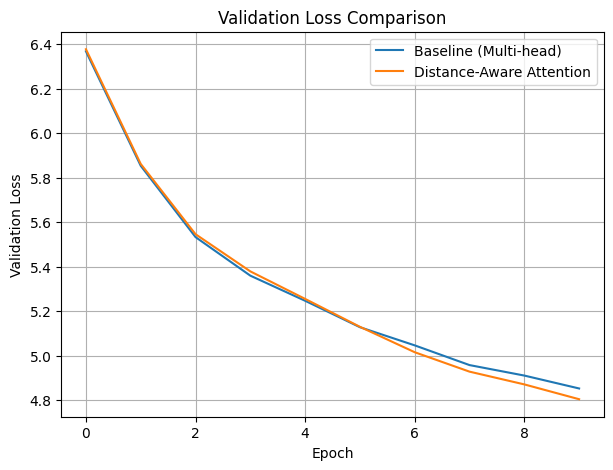

In [ ]:
plt.figure(figsize=(7,5))
plt.plot(baseline_val_losses, label="Baseline (Multi-head)")
plt.plot(distance_val_losses, label="Distance-Aware Attention")
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("Validation Loss Comparison")
plt.legend()
plt.grid(True)
plt.show()


Visualizing attention patterns...

[Baseline Model Attention]


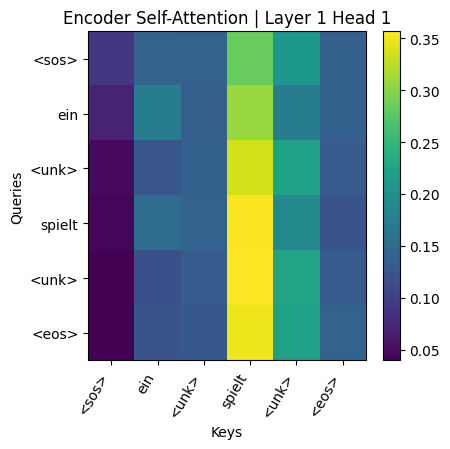

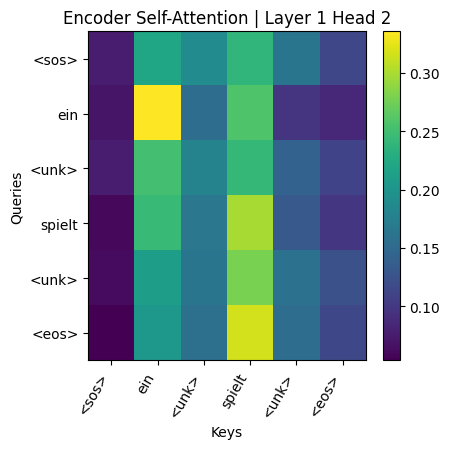

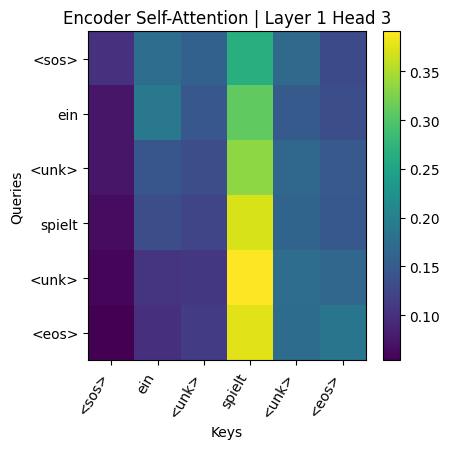

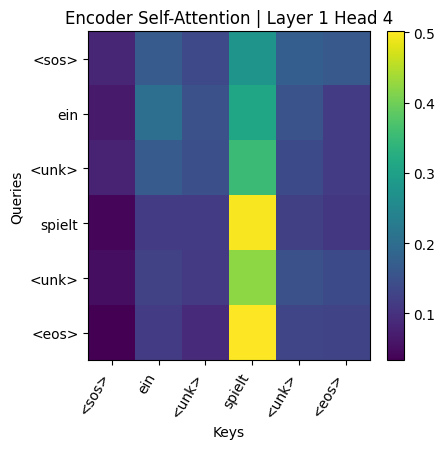

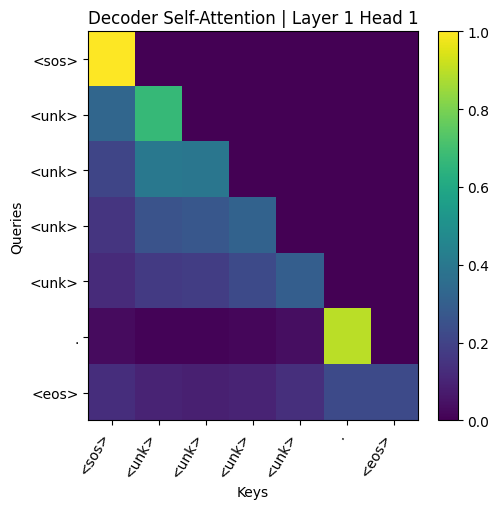

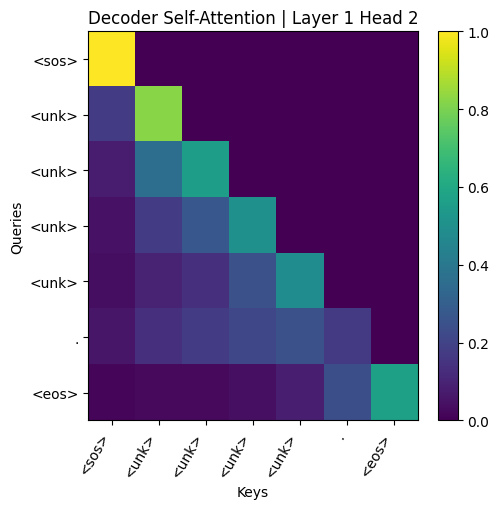

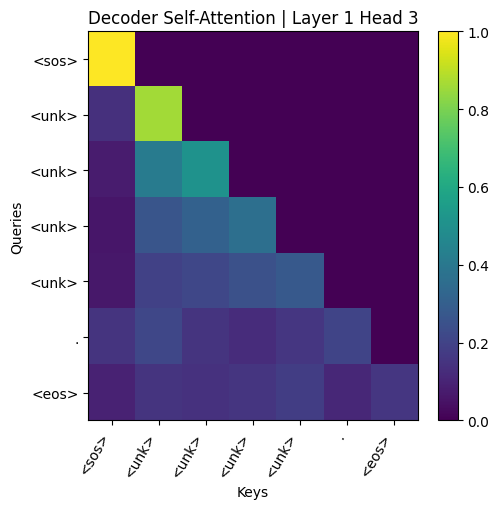

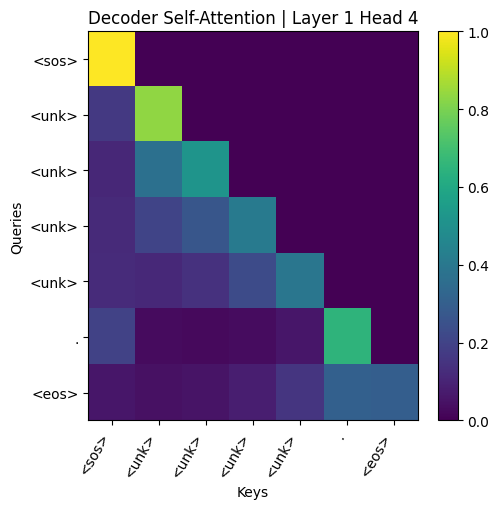

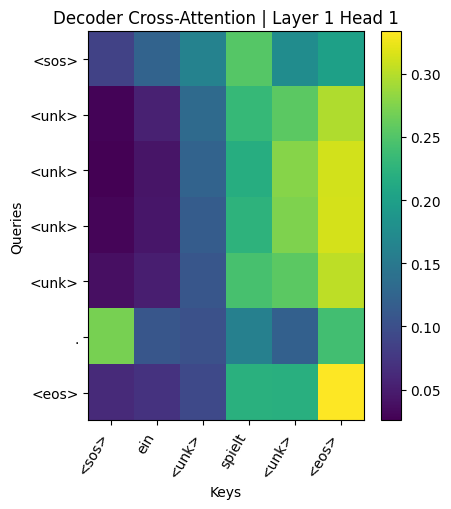

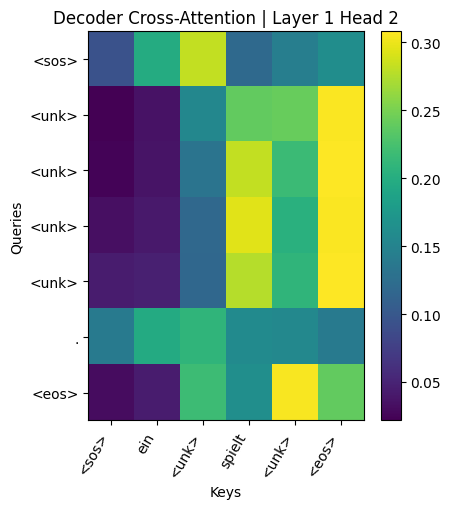

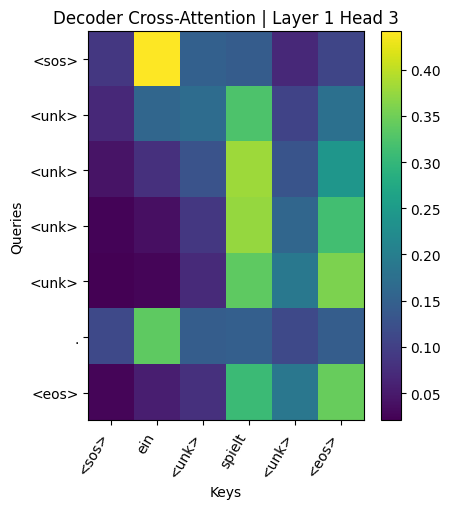

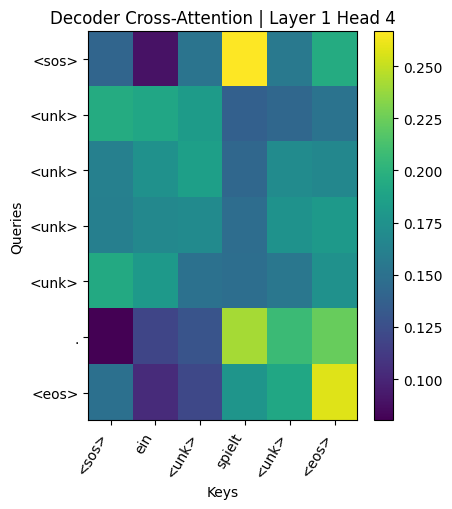

In [ ]:
print("\nVisualizing attention patterns...")

sample_src = "ein mann spielt gitarre"
sample_tgt = None

print("\n[Baseline Model Attention]")
visualize_attention(baseline_model, sample_src, sample_tgt)


[Distance-Aware Model Attention]


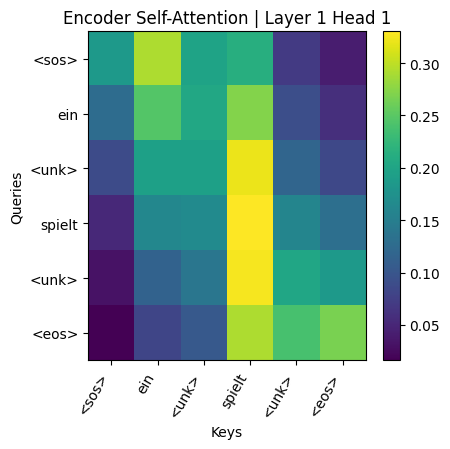

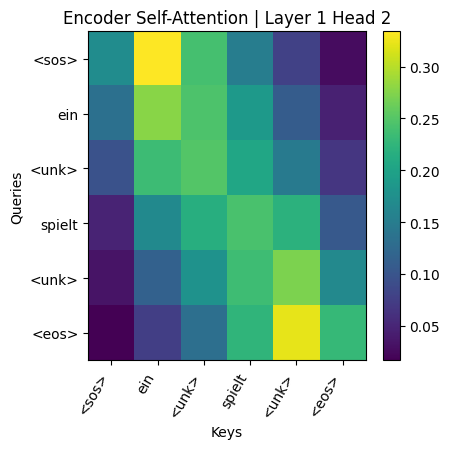

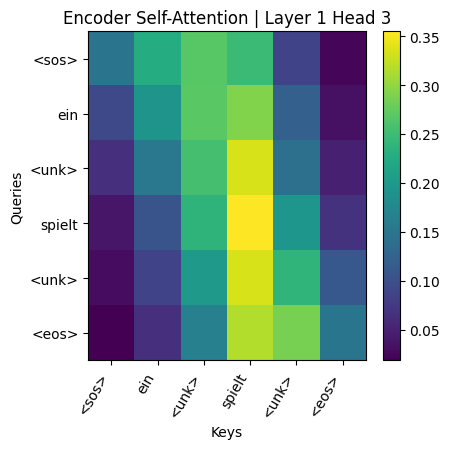

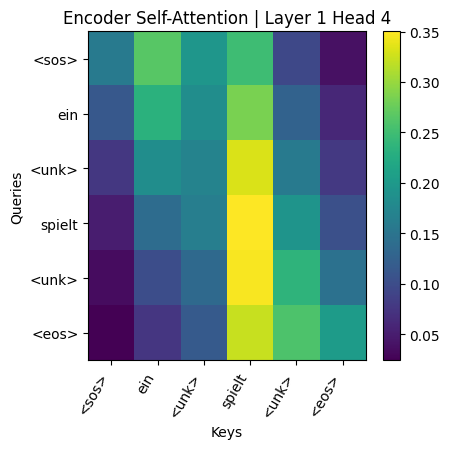

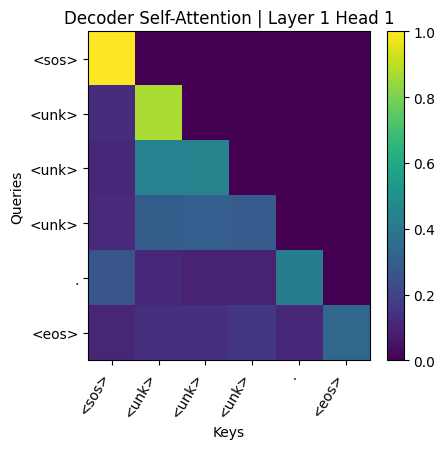

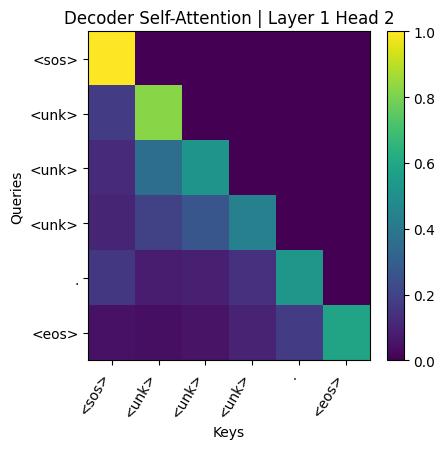

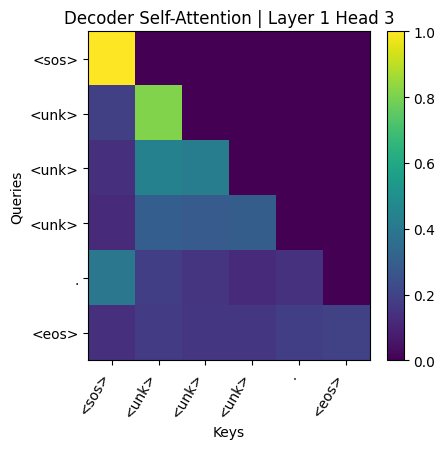

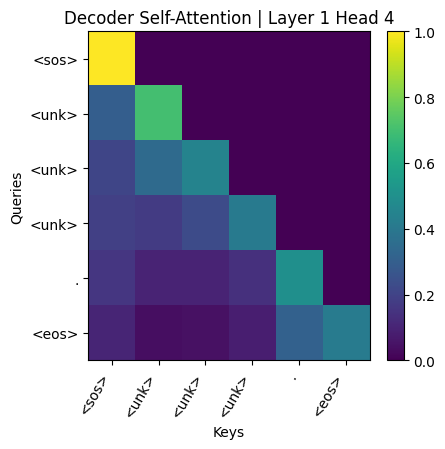

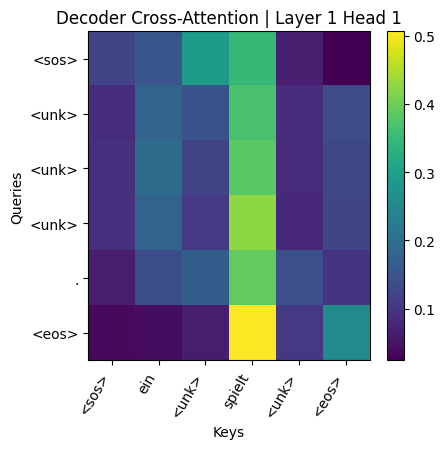

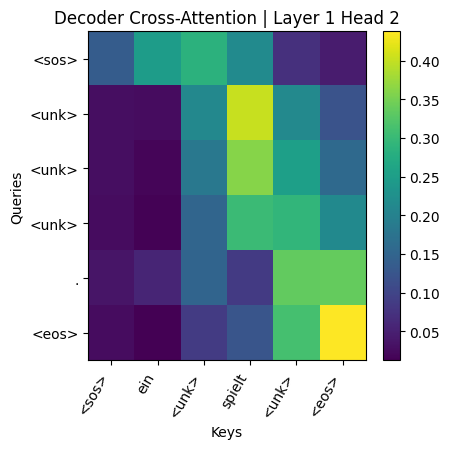

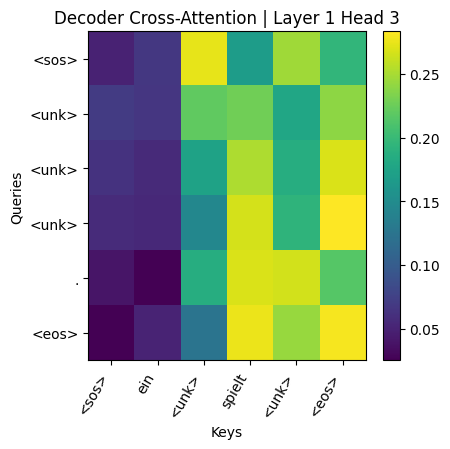

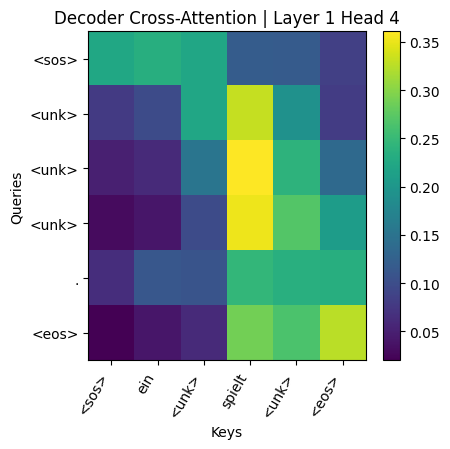

In [ ]:
print("\n[Distance-Aware Model Attention]")
visualize_attention(distance_model, sample_src, sample_tgt)



=== COMPARING BASELINE vs DISTANCE-AWARE ATTENTION ===


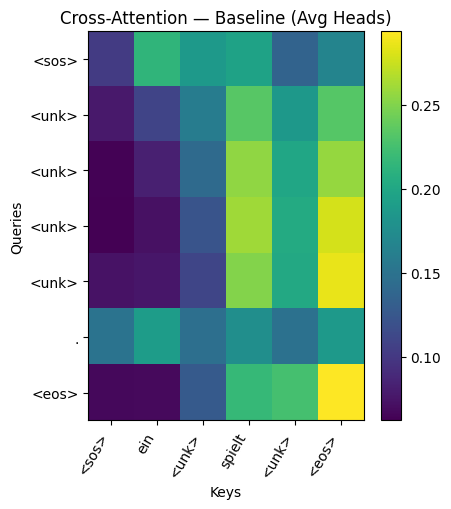

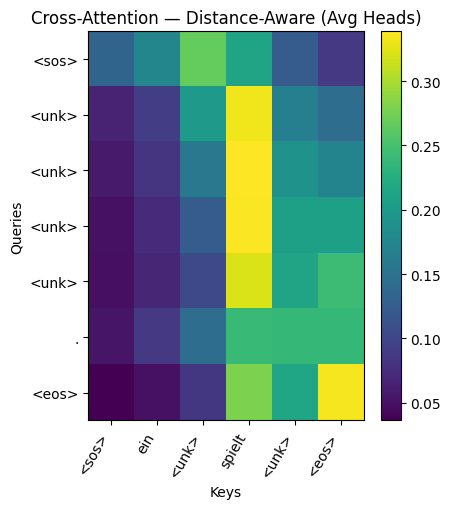


Assignment complete.


In [ ]:
def compare_attention_patterns_baseline_vs_distance(baseline, distance, src_sentence: str):

    print("\n=== COMPARING BASELINE vs DISTANCE-AWARE ATTENTION ===")

    trans, out_ids = translate_sentence(baseline, src_sentence)
    tgt_ids = [SOS_IDX] + out_ids + [EOS_IDX]

    src_ids = de_tokenizer.encode(src_sentence).ids[:98]
    src_ids = [SOS_IDX] + src_ids + [EOS_IDX]
    src = torch.tensor(src_ids, device=device).unsqueeze(0)
    tgt = torch.tensor(tgt_ids, device=device).unsqueeze(0)

    def get_avg_cross_attn(model):
        model.eval()
        with torch.no_grad():
            _ = model(src, tgt)
        A = model.get_attention_weights()['decoder_cross_attention'][0][0]
        A_avg = A.mean(dim=0).cpu().numpy()
        return A_avg

    A_base = get_avg_cross_attn(baseline)
    A_dist = get_avg_cross_attn(distance)

    src_tokens = _ids_to_tokens(de_tokenizer, src_ids)
    tgt_tokens = _ids_to_tokens(en_tokenizer, tgt_ids)

    _plot_heatmap(A_base, src_tokens, tgt_tokens, "Cross-Attention — Baseline (Avg Heads)")
    _plot_heatmap(A_dist, src_tokens, tgt_tokens, "Cross-Attention — Distance-Aware (Avg Heads)")


compare_attention_patterns_baseline_vs_distance(baseline_model, distance_model, sample_src)


print("\nAssignment complete.")

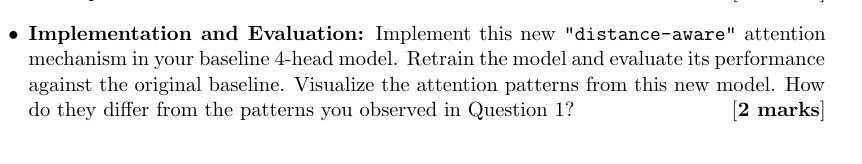

After training both models with the same hyperparameters, their validation losses ended up almost the same (around 4.8), with the Distance-Aware model doing just a little better. But when looking at the attention maps, the difference was clear. The Distance-Aware model gave much higher weights to nearby tokens, showing a strong diagonal/local focus, and the weights dropped quickly for distant tokens. In contrast, the baseline model’s attention was more spread out and connected tokens farther apart. The cross-attention in the Distance-Aware model also became a bit sharper, while still aligning properly with the source tokens. Overall, the Distance-Aware method forces the model to focus locally without hurting validation performance, but it might sometimes miss long-range connections.